# SNS process -  Rate Distortion

In [4]:
import numpy as np

In [5]:
SNS_transition_matrix = np.array([ [[0.5, 0.5], [0.0, 0.5]], [[.0, .0], [0.5, .0]]])
p = q = 0.5
# Parameters for approximating the SNS
M = N = 10  # Past and future lengths

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kl_div
import seaborn as sns

def interevent_distribution(n, p, q):
    """
    Calculates the interevent distribution F(n) for the SNS, 
    see Eq. 15 in arxiv.org:1408.6876
    
    Parameters:
    n (int or array): Number of 0's between consecutive 1's
    p, q (float): SNS parameters (transition probabilities)
    
    Returns:
    float or array: F(n) values
    """
    if isinstance(n, np.ndarray):
        result = np.zeros_like(n, dtype=float)
        for i, val in enumerate(n):
            result[i] = interevent_distribution(val, p, q)
        return result
    
    if n < 0:
        print("Error n is less than 0")
        
    if abs(p - q) < 1e-10:  # p = q case
        return (1-p)**2 * n * (p**(n-1))
    else:
        print("p not equal to q error")

def survival_function(n, p, q):
    """
    Calculates the survival function w(n) for the SNS, 
    summing over F(n) and using the geometric series.
    
    Parameters:
    n (int or array): Threshold value
    p, q (float): SNS parameters
    
    Returns:
    float or array: w(n) values
    """
    if isinstance(n, np.ndarray):
        result = np.zeros_like(n, dtype=float)
        for i, val in enumerate(n):
            result[i] = survival_function(val, p, q)
        return result
    
    if n < 0:
        print("Error n is less than 0")
    
    if abs(p - q) < 1e-10:  # p = q case
        return (p**(n-1))*(p + n*(1-p))
    else:  # p ≠ q case
        print("p not equal to q error")

def mean_interevent(p, q):
    """
    Calculates the mean interevent count μ for the SNS,
    summing over w(n) and using the geometric series.
    
    Parameters:
    p, q (float): SNS parameters
    
    Returns:
    float: Mean interevent count
    """
    if abs(p - q) < 1e-10:  # p = q case
        return (1+p)/(1-p)
    else:  # p ≠ q case
        print("p not equal to q error")

def joint_probability(p, q, M=10):
    """
    Calculate the joint probability distribution p(σ+,σ-) for the SNS,
    see App. B, pg. 15 in arxiv.org:1408.6876. Sum over aggregate states
    where relevant and use the geometric series.
    
    Parameters:
    p, q (float): SNS parameters
    M (int): Finite-time approximation cutoff
    
    Returns:
    numpy.ndarray: Joint probability matrix
    """
    # Calculate joint probability
    joint_prob = np.zeros((M+1, M+1))
    mu = mean_interevent(p, q)
    
    for sigma_plus in range(M+1):
        for sigma_minus in range(M+1):
            if sigma_plus == M and sigma_minus == M:
                # Both are aggregate states
                if abs(p - q) < 1e-10:  # p = q case
                    joint_prob[sigma_plus, sigma_minus] = 2*p**(2*M-1) * (M*(1-p)+p)  /(mu + 1)
                else:  # p ≠ q case
                    print("p not equal to q error")
            elif sigma_plus == M:
                # Forward state is aggregate
                if abs(p - q) < 1e-10:  # p = q case
                    joint_prob[sigma_plus, sigma_minus] = (p**sigma_minus*p**M)*((1-p)/p *(sigma_minus+M)+1) / (mu + 1)
                else:  # p ≠ q case
                    print("p not equal to q error")
            elif sigma_minus == M:
                # Reverse state is aggregate
                if abs(p - q) < 1e-10:  # p = q case
                    joint_prob[sigma_plus, sigma_minus] = (p**sigma_plus*p**M)*((1-p)/p *(sigma_plus+M)+1) / (mu + 1)
                else:  # p ≠ q case
                    print("p not equal to q error")
            else:
                # Regular states
                joint_prob[sigma_plus, sigma_minus] = interevent_distribution(sigma_plus + sigma_minus, p, q) / (mu + 1)
                
    return joint_prob

def forward_probability(p, q, M=10):
    """
    Calculate the probability distribution p(σ+) for the SNS,
    see App. A, pg. 13 in arxiv.org:1408.6876.
    
    Parameters:
    p, q (float): SNS parameters
    M (int): Finite-time approximation cutoff
    
    Returns:
    numpy.ndarray: Forward probability distribution
    """
    mu = mean_interevent(p, q)
    prob_sigma_plus = np.zeros(M+1)
    
    # Calculate probabilities for states below the cutoff
    for n in range(M+1):
        prob_sigma_plus[n] = survival_function(n, p, q) / (mu + 1)
    
    return prob_sigma_plus

def conditional_probability_minus_given_plus(joint_prob, p_sigma_plus):
    """
    Calculate p(σ-|σ+) from joint and marginal distributions.
    
    Parameters:
    joint_prob: Joint probability matrix p(σ+,σ-)
    p_sigma_plus: Marginal probability p(σ+)
    
    Returns:
    numpy.ndarray: Conditional probability matrix p(σ-|σ+)
    """
    M = len(p_sigma_plus) - 1
    p_sigma_minus_given_plus = np.zeros((M+1, M+1))
    
    for sigma_plus in range(M+1):
        if p_sigma_plus[sigma_plus] > 0:
            p_sigma_minus_given_plus[sigma_plus, :] = joint_prob[sigma_plus, :] / p_sigma_plus[sigma_plus]
    
    return p_sigma_minus_given_plus

def safe_kl_divergence(p, q):
    """
    Safely compute KL divergence between distributions p and q.
    Handles zeros in p and q appropriately.
    """
    # Where p is 0, the KL contribution is 0
    safe_p = np.copy(p)
    safe_q = np.copy(q)
    
    # Set very small values to avoid division by zero
    safe_q[safe_q < 1e-10] = 1e-10
    
    # Calculate KL only where p > 0
    kl = np.zeros_like(p)
    positive_p = safe_p > 0
    if np.any(positive_p):
        kl[positive_p] = safe_p[positive_p] * np.log2(safe_p[positive_p] / safe_q[positive_p])
    
    return np.sum(kl)

def causal_information_bottleneck(joint_prob, p_sigma_plus, beta_values, num_clusters, 
                                 default_restarts=10, default_iter=300, 
                                 max_restarts=50, max_iter=500,
                                 enforce_monotonicity=True,
                                 convergence_threshold=1e-6):
    """
    Implement the Causal Information Bottleneck (CIB) algorithm using equations 14-16
    from the paper.
    
    Parameters:
    joint_prob: Joint probability matrix p(σ+,σ-)
    p_sigma_plus: Marginal probability p(σ+)
    beta_values: List of beta values to compute the information curve
    num_clusters: Number of clusters to use in the representation
    default_restarts: Default number of random restarts
    default_iter: Default maximum number of iterations
    max_restarts: Maximum number of restarts for non-monotonic points
    max_iter: Maximum iterations for non-monotonic points
    enforce_monotonicity: Whether to enforce monotonicity of the information function
    convergence_threshold: Threshold for declaring convergence
    
    Returns:
    tuple: (rate_values, distortion_values, feature_curve)
    """
    M = len(p_sigma_plus) - 1
    p_sigma_minus = np.sum(joint_prob, axis=0)  # Marginal p(σ-)
    p_sigma_minus_given_plus = conditional_probability_minus_given_plus(joint_prob, p_sigma_plus)
    
    rate_values = []       # I[R;σ+]
    distortion_values = []  # I[σ+;σ-|R] or equivalently I[σ+;σ-] - I[R;σ-]
    feature_curve = []     # (β, I[R;σ+]) pairs
    
    # Calculate total mutual information I[σ+;σ-]
    total_mi = 0
    for i in range(M+1):
        for j in range(M+1):
            if joint_prob[i,j] > 0:
                total_mi += joint_prob[i,j] * np.log2(joint_prob[i,j] / (p_sigma_plus[i] * p_sigma_minus[j]))
    
    print(f"Total mutual information I[σ+;σ-] = {total_mi:.6f} bits")
    
    # Process each beta value
    prev_rate = None
    prev_distortion = None
    
    total_betas = len(beta_values)
    for idx, beta in enumerate(beta_values):
        # Print progress percentage and current beta
        progress = (idx / total_betas) * 100
        print("###########################################################")
        print(f"[{progress:.1f}%] Processing β={beta:.6f}")
        
        # Default parameters for this beta
        num_restarts_for_beta = default_restarts
        max_iter_for_beta = default_iter
        
        # Run CIB for this beta
        rate, distortion = _run_cib_for_beta(
            beta, p_sigma_plus, p_sigma_minus, p_sigma_minus_given_plus, 
            total_mi, M, num_clusters, num_restarts_for_beta, max_iter_for_beta,
            convergence_threshold
        )
        
        # Check monotonicity with previous point
        if enforce_monotonicity and prev_rate is not None and prev_distortion is not None:
            # If distortion increased, rate should decrease (or stay the same)
            if distortion > prev_distortion and rate > prev_rate + 1e-4:
                print(f"Non-monotonic point detected at β={beta}. Rerunning with increased parameters.")
                # Rerun with increased parameters
                rate, distortion = _run_cib_for_beta(
                    beta, p_sigma_plus, p_sigma_minus, p_sigma_minus_given_plus, 
                    total_mi, M, num_clusters, max_restarts, max_iter,
                    convergence_threshold
                )
        
        rate_values.append(rate)
        distortion_values.append(distortion)
        feature_curve.append((beta, rate))
        
        # Update previous values for next iteration
        prev_rate = rate
        prev_distortion = distortion
    
    return np.array(rate_values), np.array(distortion_values), np.array(feature_curve)

def _run_cib_for_beta(beta, p_sigma_plus, p_sigma_minus, p_sigma_minus_given_plus, 
                     total_mi, M, num_clusters, num_restarts, max_iter, 
                     convergence_threshold):
    """
    Helper function to run CIB algorithm for a single beta value.
    """
    best_objective = -np.inf
    best_rate = None
    best_distortion = None
    
    for restart in range(num_restarts):
        # Initialize p_t(r|σ+) randomly and normalize
        pt_r_given_sigma_plus = np.random.random((M+1, num_clusters))
        for sigma_plus in range(M+1):
            pt_r_given_sigma_plus[sigma_plus, :] /= np.sum(pt_r_given_sigma_plus[sigma_plus, :])
        
        # Initialize p_t(r)
        pt_r = np.zeros(num_clusters)
        for r in range(num_clusters):
            pt_r[r] = np.sum(pt_r_given_sigma_plus[:, r] * p_sigma_plus)
        
        # Initialize p_t(σ-|r)
        pt_sigma_minus_given_r = np.zeros((num_clusters, M+1))
        for r in range(num_clusters):
            if pt_r[r] > 0:
                for sigma_minus in range(M+1):
                    value = 0
                    for sigma_plus in range(M+1):
                        if p_sigma_plus[sigma_plus] > 0:
                            bayes = pt_r_given_sigma_plus[sigma_plus, r] * p_sigma_plus[sigma_plus] / pt_r[r]
                            value += p_sigma_minus_given_plus[sigma_plus, sigma_minus] * bayes
                    pt_sigma_minus_given_r[r, sigma_minus] = value
        
        # Iterate until convergence
        for iteration in range(max_iter):
            # Equation 14: Update p_t(r|σ+)
            new_pt_r_given_sigma_plus = np.zeros((M+1, num_clusters))
            for sigma_plus in range(M+1):
                for r in range(num_clusters):
                    # Calculate KL divergence: D_KL[p(σ-|σ+) || p_t(σ-|r)]
                    kl = safe_kl_divergence(p_sigma_minus_given_plus[sigma_plus, :], pt_sigma_minus_given_r[r, :])
                    # Check if -beta * kl is too large (causing overflow)
                    exp_term = -beta * kl
                    # Use np.clip to prevent overflow
                    exp_term = np.clip(exp_term, -700, 700)  # exp(700) is close to the max float value
            
                    new_pt_r_given_sigma_plus[sigma_plus, r] = pt_r[r] * np.exp2(exp_term)
                #Calculate normalization term accordination to Eq. B6 in arxiv.org:1408.6876
                # normalization_term_arg = np.sum(-np.log2(pt_r) + exp_term - np.log2(pt_r_given_sigma_plus[sigma_plus,r]))
                # normalization_term = np.exp2(-normalization_term_arg) 
                # new_pt_r_given_sigma_plus[sigma_plus, r] /= normalization_term
                
                
            # # Normalize
            for sigma_plus in range(M+1):
              sum_value = np.sum(new_pt_r_given_sigma_plus[sigma_plus, :])
                # # if sum_value <= 0 or not np.isfinite(sum_value):  # Only debug if there's an issue
                # #     print(f"Normalization issue - sigma_plus: {sigma_plus}, sum value: {sum_value}, values: {new_pt_r_given_sigma_plus[sigma_plus, :]}")
                # #     new_pt_r_given_sigma_plus[sigma_plus, :] = 1.0 / num_clusters  # Set to uniform distribution
                # # else:
                # #     new_pt_r_given_sigma_plus[sigma_plus, :] /= sum_value
              new_pt_r_given_sigma_plus[sigma_plus, :] /= sum_value
              if sum_value is None:
                print('Normalization',sum_value,'for large numbers should tend towards (for SNS)', np.sum(pt_r))
            
            # Equation 15: Update p_t(r)
            new_pt_r = np.zeros(num_clusters)
            for r in range(num_clusters):
                new_pt_r[r] = np.sum(new_pt_r_given_sigma_plus[:, r] * p_sigma_plus)
            
            # Equation 16: Update p_t(σ-|r)
            new_pt_sigma_minus_given_r = np.zeros((num_clusters, M+1))
            for r in range(num_clusters):
                if new_pt_r[r] > 0:
                    for sigma_minus in range(M+1):
                        value = 0
                        for sigma_plus in range(M+1):
                            if p_sigma_plus[sigma_plus] > 0:
                                bayes = new_pt_r_given_sigma_plus[sigma_plus, r] * p_sigma_plus[sigma_plus] / new_pt_r[r]
                                value += p_sigma_minus_given_plus[sigma_plus, sigma_minus] * bayes
                        new_pt_sigma_minus_given_r[r, sigma_minus] = value
            
            # # Check for convergence
            # if np.max(np.abs(new_pt_r_given_sigma_plus - pt_r_given_sigma_plus)) < convergence_threshold:
            #     break
            
            pt_r_given_sigma_plus = new_pt_r_given_sigma_plus
            
            # Check that pt_r_given_sigma_plus is normalized for each sigma_plus
            for sigma_plus in range(M+1):
                sum_prob = np.sum(pt_r_given_sigma_plus[sigma_plus, :])
                if not np.isclose(sum_prob, 1.0, rtol=1e-5):
                    print(f"Warning: pt_r_given_sigma_plus not normalized for sigma_plus={sigma_plus}. Sum={sum_prob}")
            pt_r = new_pt_r
            pt_sigma_minus_given_r = new_pt_sigma_minus_given_r
        
        # Calculate I[R;σ+] (rate)
        rate = 0
        for sigma_plus in range(M+1):
            for r in range(num_clusters):
                if pt_r_given_sigma_plus[sigma_plus, r] > 0 and pt_r[r] > 0:
                    rate += p_sigma_plus[sigma_plus] * pt_r_given_sigma_plus[sigma_plus, r] * \
                            np.log2(pt_r_given_sigma_plus[sigma_plus, r] / (pt_r[r]))
        
        # Calculate I[R;σ-] (relevant information)
        info_r_sigma_minus = 0
        for r in range(num_clusters):
            for sigma_minus in range(M+1):
                pt_r_sigma_minus = pt_r[r] * pt_sigma_minus_given_r[r, sigma_minus]
                if pt_r_sigma_minus > 0:
                    denominator = pt_r[r] * p_sigma_minus[sigma_minus]
                    # Print debug information to understand the divide by zero issue
                    # if denominator <= 0:
                    #     print(f"Divide by zero issue at r={r}, sigma_minus={sigma_minus}:")
                    #     print(f"  pt_r[r] = {pt_r[r]}")
                    #     print(f"  p_sigma_minus[sigma_minus] = {p_sigma_minus[sigma_minus]}")
                    #     print(f"  pt_sigma_minus_given_r[r, sigma_minus] = {pt_sigma_minus_given_r[r, sigma_minus]}")
                    #     print(f"  pt_r_sigma_minus = {pt_r_sigma_minus}")
                    
                    info_r_sigma_minus += pt_r_sigma_minus * \
                                        np.log2(pt_r_sigma_minus / (pt_r[r] * p_sigma_minus[sigma_minus]))
        
        # Distortion = I[σ+;σ-] - I[R;σ-]
        distortion = total_mi - info_r_sigma_minus
        
        # Calculate objective function
        objective = info_r_sigma_minus - (1/beta) * rate
        #print('check if these are equal for even function',info_r_sigma_minus,rate,np.abs(info_r_sigma_minus-rate))
        # if objective < 0:
        #     print('objective',objective,'info_r_sigma_minus',info_r_sigma_minus,'rate',rate)
        #     print('pt_r_given_sigma_plus',pt_r_given_sigma_plus)
        #     print('pt_r',pt_r)
        #     print('pt_sigma_minus_given_r',pt_sigma_minus_given_r)
        
        
        if objective > best_objective:
            best_objective = objective
            best_rate = rate
            best_distortion = distortion
    
    return best_rate, best_distortion

def plot_information_function(rate_values, distortion_values, E, C_mu):
    """
    Plot the information function (code rate vs. distortion).
    
    Parameters:
    rate_values: Array of rate values (I[R;σ+])
    distortion_values: Array of distortion values (I[σ+;σ-|R])
    E: Excess entropy (I[σ+;σ-])
    C_mu: Statistical complexity (H[σ+])
    """
    import pandas as pd
    
    # Read data from first_data.csv
    csv_data = pd.read_csv('first_data.csv')
    csv_distortion_values = csv_data.iloc[:, 0]
    csv_rate_values = csv_data.iloc[:, 1]
    
    plt.figure(figsize=(10, 6))
    
    # Plot the original data from CSV as a scatter plot in blue
    plt.scatter(csv_distortion_values, csv_rate_values, color='b', label='original')
    
    # Plot the given rate and distortion values in red
    plt.plot(distortion_values, rate_values, 'ro-', label='reproducing')
    
    plt.axhline(y=C_mu, color='k', linestyle='-.', label=r'$C_\mu$')
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axvline(x=E, color='k', linestyle=':', label=r'$E$')
    plt.xlabel(r'$I[\overset{\leftarrow}{X};\overset{\rightarrow}{X}|R]$')
    plt.ylabel(r'$I[R;\overset{\leftarrow}{X}]$')
    plt.title('Information Function for SNS')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # Highlight x=0 and y=0 axes in solid black lines
    plt.axhline(y=0, color='black')
    plt.axvline(x=0, color='black')
    
    plt.tight_layout()
    plt.show()

def plot_feature_curve(feature_curve, C_mu):
    """
    Plot the feature curve (rate vs. beta) and compare with data from a CSV file.
    
    Parameters:
    feature_curve: Array of (beta, rate) pairs
    C_mu: Statistical complexity (H[σ+])
    """
    import pandas as pd
    
    # Extract data from feature_curve
    betas = feature_curve[:, 0]
    rates = feature_curve[:, 1]
    
    # Read data from CSV file
    csv_data = pd.read_csv('second_data.csv')
    csv_betas = csv_data.iloc[:, 0]
    csv_rates = csv_data.iloc[:, 1]
    
    plt.figure(figsize=(10, 6))
    
    # Plot feature_curve data with lines
    plt.semilogx(betas, rates, 'ro-', label='reproducing')
    
    # Plot CSV data as a scatter plot
    plt.scatter(csv_betas, csv_rates, color='b', label='original')
    
    # Plot C_mu line
    plt.axhline(y=C_mu, color='k', linestyle='--', label=r'$C_\mu$')
    
    # Set axis labels with arrows
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$I[R;\overset{\leftarrow}{X}]$')
    
    plt.title('Feature Curve for SNS')
    plt.legend(loc='upper left')
    plt.grid(True)
    
    # Highlight x=0 and y=0 axes in solid black lines
    plt.axhline(y=0, color='black')
    plt.axvline(x=0, color='black')
    
    plt.tight_layout()
    plt.show()

def run_sns_cib_analysis(p=0.5, q=0.5, M=10, num_clusters=10, beta_values=np.logspace(-1, 5, 20),enforce_monotonicity=True, default_restarts=500, default_iter=300, max_restarts=5000, max_iter=500):
    """
    Run the CIB analysis on the SNS process and plot the results.
    
    Parameters:
    p, q (float): SNS parameters
    M (int): Finite-time approximation cutoff
    num_clusters (int): Number of clusters to use in the representation
    beta_values: Array of beta values to compute
    enforce_monotonicity: Whether to enforce monotonicity of the information function
    """
    # Calculate joint and marginal distributions
    joint_prob = joint_probability(p, q, M)
    p_sigma_plus = forward_probability(p, q, M)
    
    # Verify that distributions are normalized
    total_joint = np.sum(joint_prob)
    total_sigma_plus = np.sum(p_sigma_plus)
    
    print(f"Joint distribution sum: {total_joint:.10f} (should be close to 1.0)")
    print(f"Forward state distribution sum: {total_sigma_plus:.10f} (should be close to 1.0)")
    
    if not np.isclose(total_joint, 1.0, rtol=1e-5):
        print("WARNING: Joint probability distribution does not sum to 1.0")
        # Normalize to ensure proper distribution
        joint_prob = joint_prob / total_joint
    
    if not np.isclose(total_sigma_plus, 1.0, rtol=1e-5):
        print("WARNING: Forward state probability distribution does not sum to 1.0")
        # Normalize to ensure proper distribution
        p_sigma_plus = p_sigma_plus / total_sigma_plus
    
    # Calculate reverse-time marginal probability
    p_sigma_minus = np.sum(joint_prob, axis=0)
    
    # Calculate excess entropy (mutual information between σ+ and σ-)
    E = 0
    for i in range(M+1):
        for j in range(M+1):
            if joint_prob[i,j] > 0:
                # Using log base 2 for information theory quantities in bits
                ratio = joint_prob[i,j] / (p_sigma_plus[i] * p_sigma_minus[j])
                E += joint_prob[i,j] * np.log2(ratio)
    
    # Add a sanity check
    if E < 0:
        print(f"WARNING: Calculated excess entropy is negative ({E:.6f}), which should not happen.")
        print("Checking for potential numerical issues...")
        
        # Check for numerical issues in the calculation
        min_ratio = float('inf')
        max_ratio = float('-inf')
        for i in range(M+1):
            for j in range(M+1):
                if joint_prob[i,j] > 0:
                    ratio = joint_prob[i,j] / (p_sigma_plus[i] * p_sigma_minus[j])
                    min_ratio = min(min_ratio, ratio)
                    max_ratio = max(max_ratio, ratio)
        
        print(f"Minimum ratio: {min_ratio:.10f}")
        print(f"Maximum ratio: {max_ratio:.10f}")
        
        # Try a more numerically stable calculation
        E_stable = 0
        for i in range(M+1):
            for j in range(M+1):
                if joint_prob[i,j] > 0:
                    # Avoid potential underflow/overflow in the ratio
                    log_joint = np.log2(max(joint_prob[i,j], 1e-100))
                    log_plus = np.log2(max(p_sigma_plus[i], 1e-100))
                    log_minus = np.log2(max(p_sigma_minus[j], 1e-100))
                    E_stable += joint_prob[i,j] * (log_joint - log_plus - log_minus)
        
        print(f"Recalculated excess entropy with more numerical stability: {E_stable:.6f} bits")
        E = max(0, E_stable)  # Ensure non-negative result
    
    # Calculate statistical complexity
    C_mu = -np.sum(p_sigma_plus * np.log2(p_sigma_plus + (p_sigma_plus == 0)))
    
    print(f"Excess Entropy E = {E:.6f} bits")
    print(f"Statistical Complexity C_μ = {C_mu:.6f} bits")
    
    # Run CIB algorithm
    print("Running Causal Information Bottleneck algorithm...")
    rate_values, distortion_values, feature_curve = causal_information_bottleneck(
        joint_prob, p_sigma_plus, beta_values, num_clusters, 
        default_restarts=default_restarts, default_iter=default_iter,
        max_restarts=max_restarts, max_iter=max_iter,
        enforce_monotonicity=enforce_monotonicity,
        convergence_threshold=1e-6
    )
    
    # Sort results by distortion (for smooth curves)
    idx = np.argsort(distortion_values)
    rate_values = rate_values[idx]
    distortion_values = distortion_values[idx]
    
    # Plot results
    plot_information_function(rate_values, distortion_values, E, C_mu)
    plot_feature_curve(feature_curve, C_mu)
    
    return rate_values, distortion_values, feature_curve, E, C_mu

Analyzing SNS process with parameters p=0.5, q=0.5
Using finite-time approximation with M=10 and 10 clusters
Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits
###########################################################
[0.0%] Processing β=48329.302386
###########################################################
[50.0%] Processing β=100000.000000


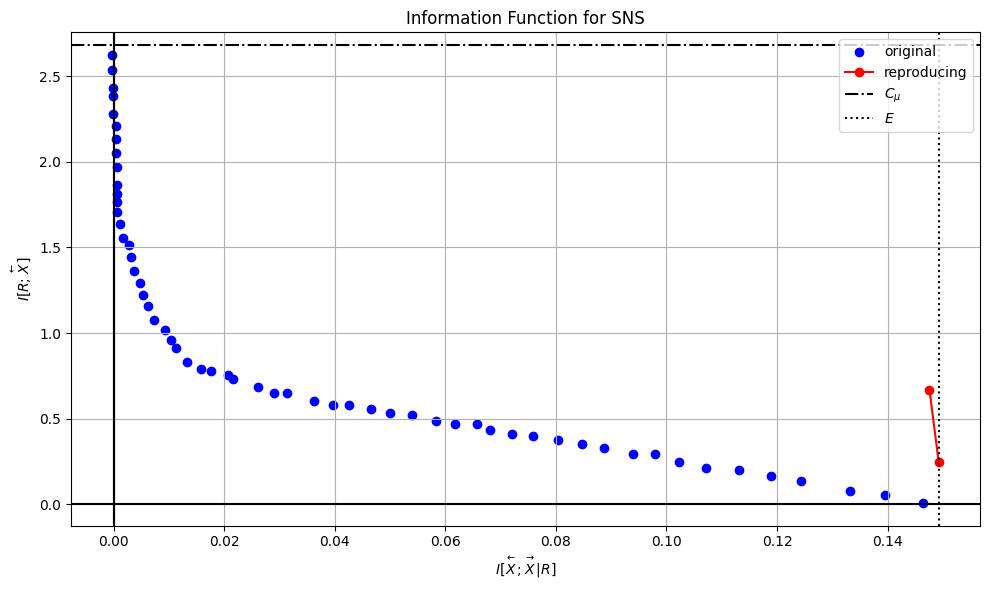

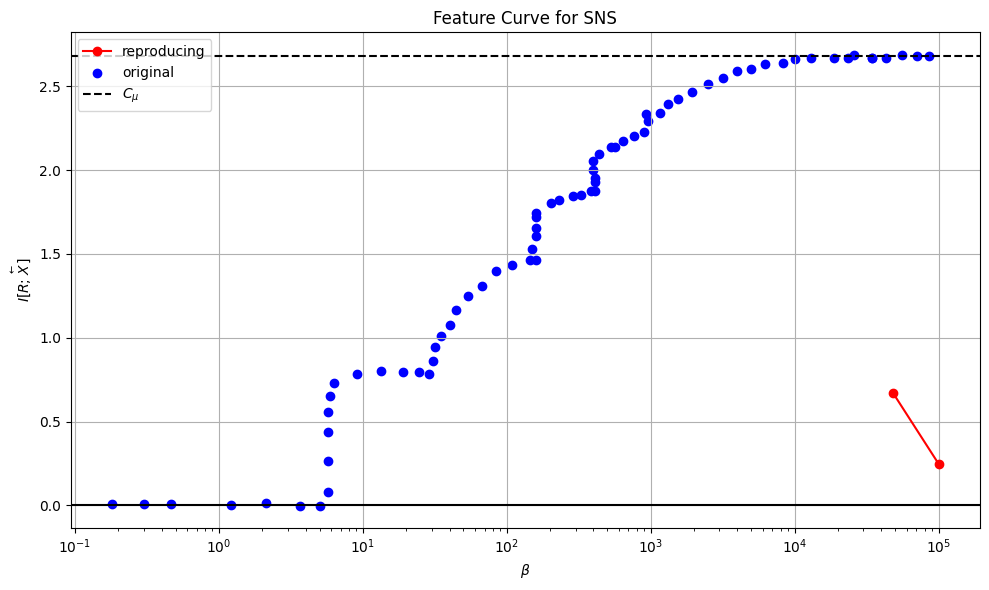

In [16]:
if __name__ == "__main__":
    # Set parameters for the SNS process
    p = 0.5
    q = 0.5
    M = 10
    num_clusters = 10
    
    print(f"Analyzing SNS process with parameters p={p}, q={q}")
    print(f"Using finite-time approximation with M={M} and {num_clusters} clusters")
    
    # Run the analysis
    results = run_sns_cib_analysis(p=p, q=q, M=M, num_clusters=num_clusters,beta_values=np.logspace(-1, 5, 20)[-2:],default_restarts=10, default_iter=300, max_restarts=5000, max_iter=500,enforce_monotonicity=False)

# EVEN 

In [14]:
def plot_information_function_even(rate_values, distortion_values, E, C_mu):
    """
    Plot the information function (code rate vs. distortion) for the Even process.
    
    Parameters:
    rate_values: Array of rate values (I[R;σ+])
    distortion_values: Array of distortion values (I[σ+;σ-|R])
    E: Excess entropy (I[σ+;σ-])
    C_mu: Statistical complexity (H[σ+])
    """
    plt.figure(figsize=(10, 6))
    
    # Plot the given rate and distortion values
    plt.plot(distortion_values, rate_values, 'ro-', label='reproducing')
    
    # For the Even process, plot a straight line connecting (0,E) and (E,0)
    # where E = C_mu
    x_line = np.array([0, E])
    y_line = np.array([E, 0])
    plt.plot(x_line, y_line, 'b-', label='original')
    
    plt.axhline(y=C_mu, color='k', linestyle='-.', label=r'$C_\mu$')
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axvline(x=E, color='k', linestyle=':', label=r'$E$')
    plt.xlabel(r'$I[\overset{\leftarrow}{X};\overset{\rightarrow}{X}|R]$')
    plt.ylabel(r'$I[R;\overset{\leftarrow}{X}]$')
    plt.title('Information Function for Even Process')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # Highlight x=0 and y=0 axes in solid black lines
    plt.axhline(y=0, color='black')
    plt.axvline(x=0, color='black')
    
    plt.tight_layout()
    plt.show()
def plot_feature_curve_even(feature_curve, C_mu):
    """
    Plot the feature curve (rate vs. beta) for the Even process.
    
    Parameters:
    feature_curve: Array of (beta, rate) pairs
    C_mu: Statistical complexity (H[σ+])
    """
    # Extract data from feature_curve
    betas = feature_curve[:, 0]
    rates = feature_curve[:, 1]
    
    plt.figure(figsize=(10, 6))
    
    # Plot feature_curve data with lines
    plt.plot(betas, rates, 'ro-', label='reproducing')
    
    # Use step function to represent the original Even process feature curve
    beta_step = np.array([0, 1, 1, 14])
    rate_step = np.array([0, 0, C_mu, C_mu])
    plt.plot(beta_step, rate_step, 'b-', label='original')
    
    # Plot C_mu line
    plt.axhline(y=C_mu, color='k', linestyle='--', label=r'$C_\mu$')
    
    # Set axis labels
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$I[R;\overset{\leftarrow}{X}]$')
    
    # Add finer granularity in x-axis ticks
    max_beta = max(betas.max(), 14)  # Use the larger of the data max or 14
    plt.xticks(np.arange(0, max_beta + 1, 0.5))  # Ticks every 0.5 units
    
    plt.title('Feature Curve for Even Process')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Highlight x=0 and y=0 axes in solid black lines
    plt.axhline(y=0, color='black')
    plt.axvline(x=0, color='black')
    
    plt.tight_layout()
    plt.show()

def run_even_process_cib_analysis(num_clusters=2, beta_values=np.linspace(0, 14, 15),enforce_monotonicity=True, default_restarts=500, default_iter=300, max_restarts=5000, max_iter=500):
    """
    Run the CIB analysis on the Even process and plot the results.
    
    Parameters:
    num_clusters (int): Number of clusters to use in the representation
    beta_values: Array of beta values to compute
    enforce_monotonicity: Whether to enforce monotonicity of the information function
    """
    # For the Even process:
    # - Forward probability p(sigma+) = (2/3, 1/3)
    # - Conditional probability p(sigma-|sigma+) = identity matrix (2x2)
    
    # Define the distributions
    p_sigma_plus = np.array([2/3, 1/3])  # Forward probability
    
    # Since p(sigma-|sigma+) is the identity matrix, the joint probability is:
    # p(sigma+, sigma-) = p(sigma+) * p(sigma-|sigma+) = p(sigma+) * I
    joint_prob = np.zeros((2, 2))
    joint_prob[0, 0] = p_sigma_plus[0]  # p(sigma+=0, sigma-=0) = p(sigma+=0)
    joint_prob[1, 1] = p_sigma_plus[1]  # p(sigma+=1, sigma-=1) = p(sigma+=1)
    
    # Calculate reverse-time marginal probability
    p_sigma_minus = np.sum(joint_prob, axis=0)
    
    # Verify that distributions are normalized
    total_joint = np.sum(joint_prob)
    total_sigma_plus = np.sum(p_sigma_plus)
    
    print(f"Joint distribution sum: {total_joint:.10f} (should be close to 1.0)")
    print(f"Forward state distribution sum: {total_sigma_plus:.10f} (should be close to 1.0)")
    
    # Calculate excess entropy (mutual information between σ+ and σ-)
    E = 0
    for i in range(2):
        for j in range(2):
            if joint_prob[i,j] > 0:
                # Using log base 2 for information theory quantities in bits
                ratio = joint_prob[i,j] / (p_sigma_plus[i] * p_sigma_minus[j])
                E += joint_prob[i,j] * np.log2(ratio)
    
    # Add a sanity check
    if E < 0:
        print(f"WARNING: Calculated excess entropy is negative ({E:.6f}), which should not happen.")
        print("Checking for potential numerical issues...")
        
        # Check for numerical issues in the calculation
        min_ratio = float('inf')
        max_ratio = float('-inf')
        for i in range(2):
            for j in range(2):
                if joint_prob[i,j] > 0:
                    ratio = joint_prob[i,j] / (p_sigma_plus[i] * p_sigma_minus[j])
                    min_ratio = min(min_ratio, ratio)
                    max_ratio = max(max_ratio, ratio)
        
        print(f"Minimum ratio: {min_ratio:.10f}")
        print(f"Maximum ratio: {max_ratio:.10f}")
        
        # Try a more numerically stable calculation
        E_stable = 0
        for i in range(2):
            for j in range(2):
                if joint_prob[i,j] > 0:
                    # Avoid potential underflow/overflow in the ratio
                    log_joint = np.log2(max(joint_prob[i,j], 1e-100))
                    log_plus = np.log2(max(p_sigma_plus[i], 1e-100))
                    log_minus = np.log2(max(p_sigma_minus[j], 1e-100))
                    E_stable += joint_prob[i,j] * (log_joint - log_plus - log_minus)
        
        print(f"Recalculated excess entropy with more numerical stability: {E_stable:.6f} bits")
        #E = max(0, E_stable)  # Ensure non-negative result
    
    # Calculate statistical complexity
    C_mu = -np.sum(p_sigma_plus * np.log2(p_sigma_plus + (p_sigma_plus == 0)))
    
    print(f"Excess Entropy E = {E:.6f} bits")
    print(f"Statistical Complexity C_μ = {C_mu:.6f} bits")
    
    # Run CIB algorithm
    print("Running Causal Information Bottleneck algorithm...")
    rate_values, distortion_values, feature_curve = causal_information_bottleneck(
        joint_prob, p_sigma_plus, beta_values, num_clusters, 
        default_restarts=default_restarts, default_iter=default_iter,
        max_restarts=max_restarts, max_iter=max_iter,
        enforce_monotonicity=enforce_monotonicity,
        convergence_threshold=1e-6
    )
    
    # Sort results by distortion (for smooth curves)
    idx = np.argsort(distortion_values)
    rate_values = rate_values[idx]
    distortion_values = distortion_values[idx]
    
    # Plot results
    plot_information_function_even(rate_values, distortion_values, E, C_mu)
    plot_feature_curve_even(feature_curve, C_mu)
    
    return rate_values, distortion_values, feature_curve, E, C_mu

## results even

Analyzing the Even process
Using 2 clusters for the analysis
Joint distribution sum: 1.0000000000 (should be close to 1.0)
Forward state distribution sum: 1.0000000000 (should be close to 1.0)
Excess Entropy E = 0.918296 bits
Statistical Complexity C_μ = 0.918296 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.918296 bits
###########################################################
[0.0%] Processing β=0.100000
###########################################################
[4.8%] Processing β=0.550000
###########################################################
[9.5%] Processing β=0.600000
###########################################################
[14.3%] Processing β=0.690000
###########################################################
[19.0%] Processing β=0.700000
###########################################################
[23.8%] Processing β=0.750000
###########################################################
[28.6%] Processing β=0.800000
###

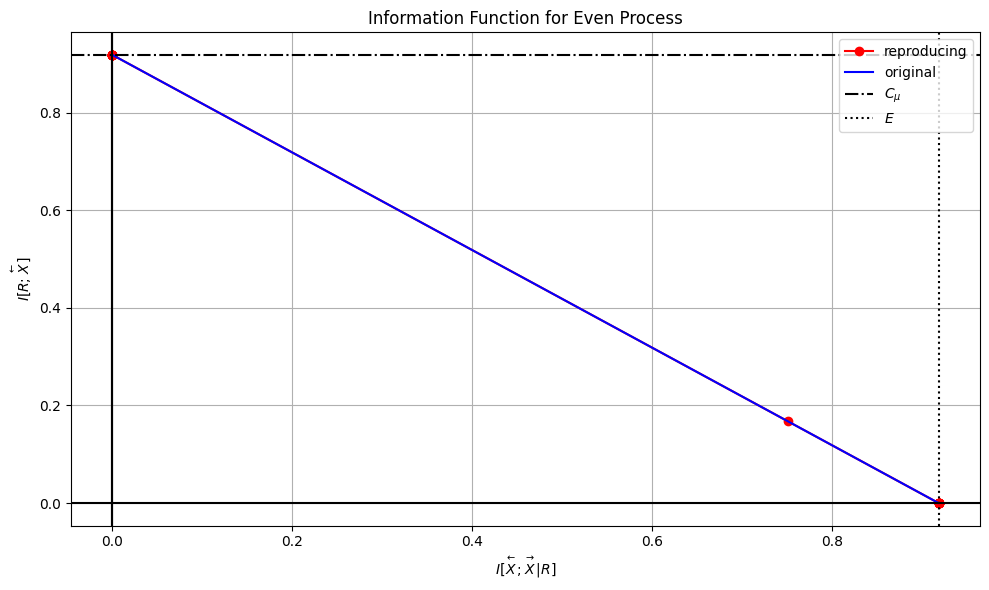

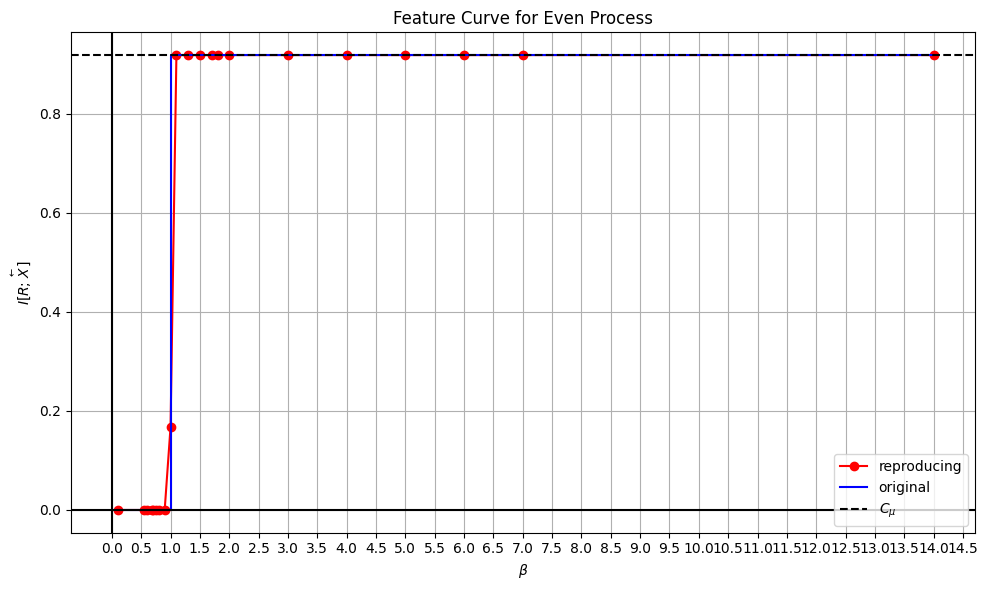

In [15]:
if __name__ == "__main__":
    # Set parameters for the Even process
    num_clusters_even = 2
    beta_even = np.array([0.1,0.55,0.6,0.69,0.7,0.75,0.8,0.9,1.,1.1,1.3,1.5,1.7,1.8,  2.,  3.,  4.,  5.,  6.,  7., 14.])
    print(f"Analyzing the Even process")
    print(f"Using {num_clusters_even} clusters for the analysis")
    
    # Run the analysis
    results_even = run_even_process_cib_analysis(num_clusters=num_clusters_even,beta_values=beta_even,default_restarts=10, default_iter=300, max_restarts=5000, max_iter=500)

In [98]:
results_even

(array([ 9.18295834e-01,  9.18295834e-01,  9.18295834e-01,  9.18295834e-01,
         9.18295834e-01,  9.18295834e-01,  9.18295834e-01,  2.08050463e-01,
         1.54472144e-16,  6.62235291e-17,  6.37824645e-17,  2.84656026e-17,
         0.00000000e+00, -1.52047382e-17,  0.00000000e+00,  1.30357078e-18]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.71024537, 0.91829583, 0.91829583,
        0.91829583, 0.91829583, 0.91829583, 0.91829583, 0.91829583,
        0.91829583]),
 array([[ 1.00000000e-01,  0.00000000e+00],
        [ 5.50000000e-01, -1.52047382e-17],
        [ 6.00000000e-01,  0.00000000e+00],
        [ 6.90000000e-01,  6.37824645e-17],
        [ 7.00000000e-01,  1.30357078e-18],
        [ 7.50000000e-01,  1.54472144e-16],
        [ 8.00000000e-01,  2.84656026e-17],
        [ 9.00000000e-01,  6.62235291e-17],
        [ 1.00000000e+00,  2.08050463e-01],
        [ 2.00000000e+00,  9.18295834e-01],
        [ 3.00000000e+00,  9

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


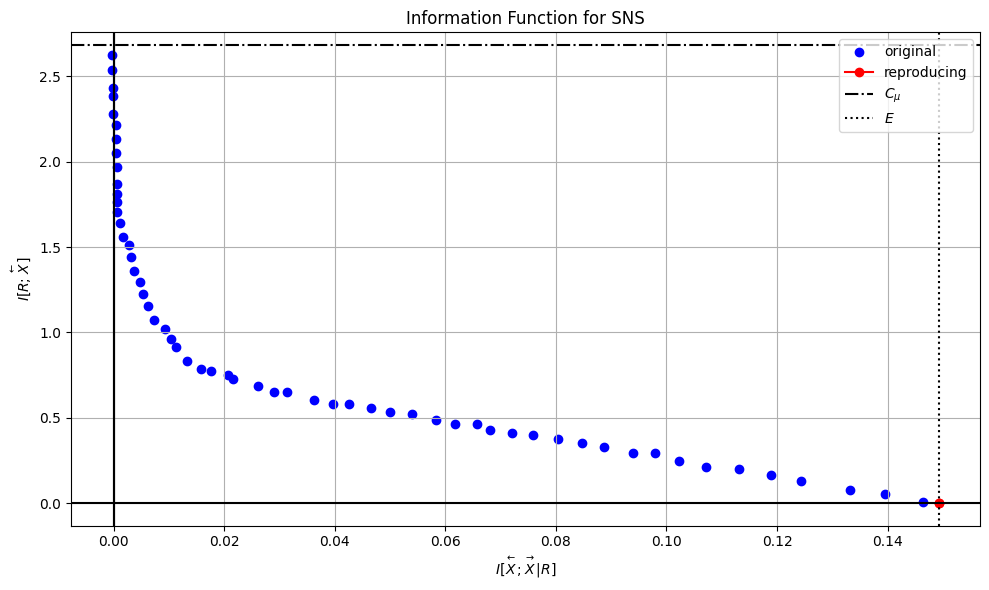

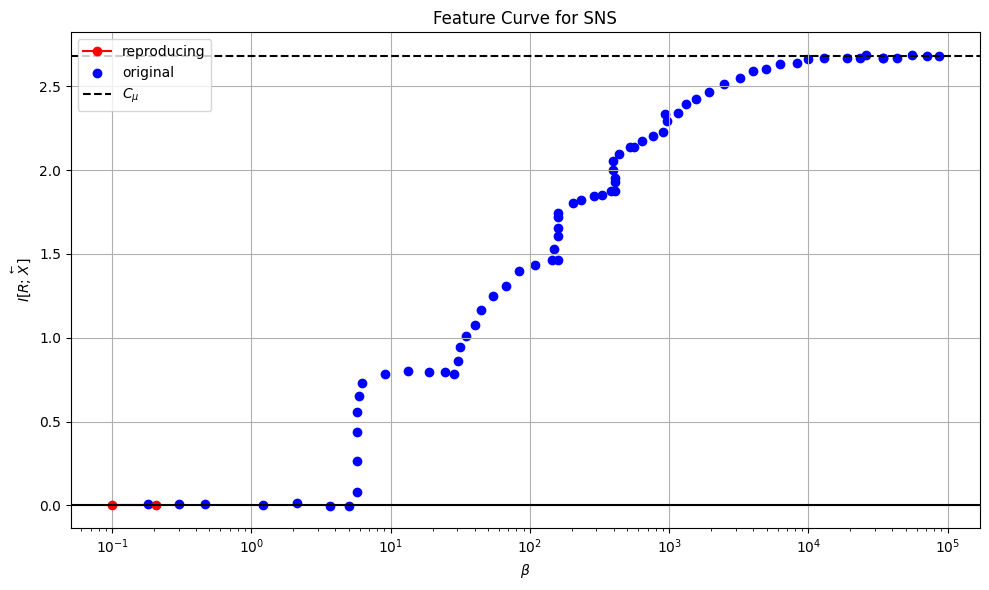

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


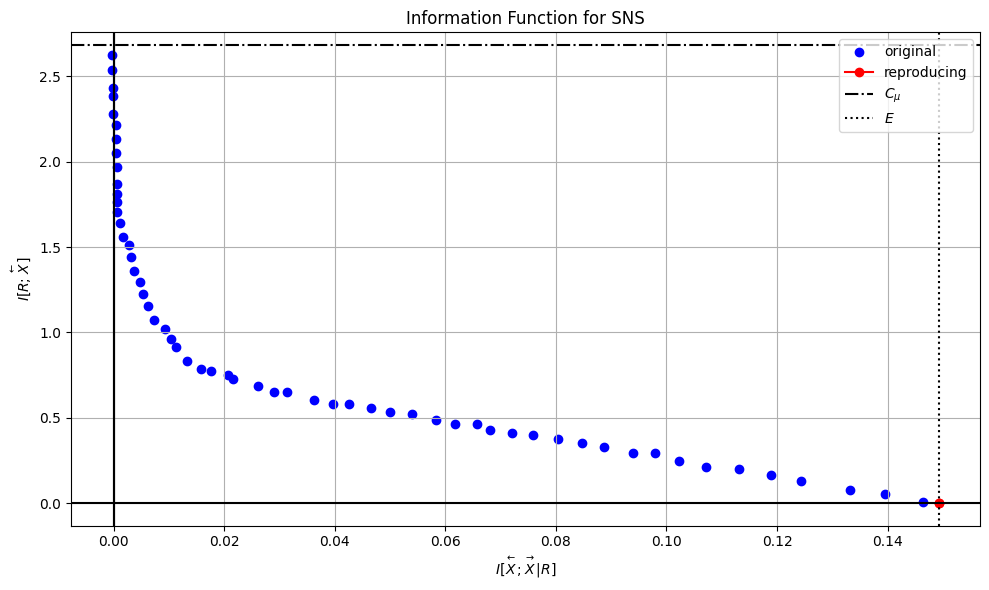

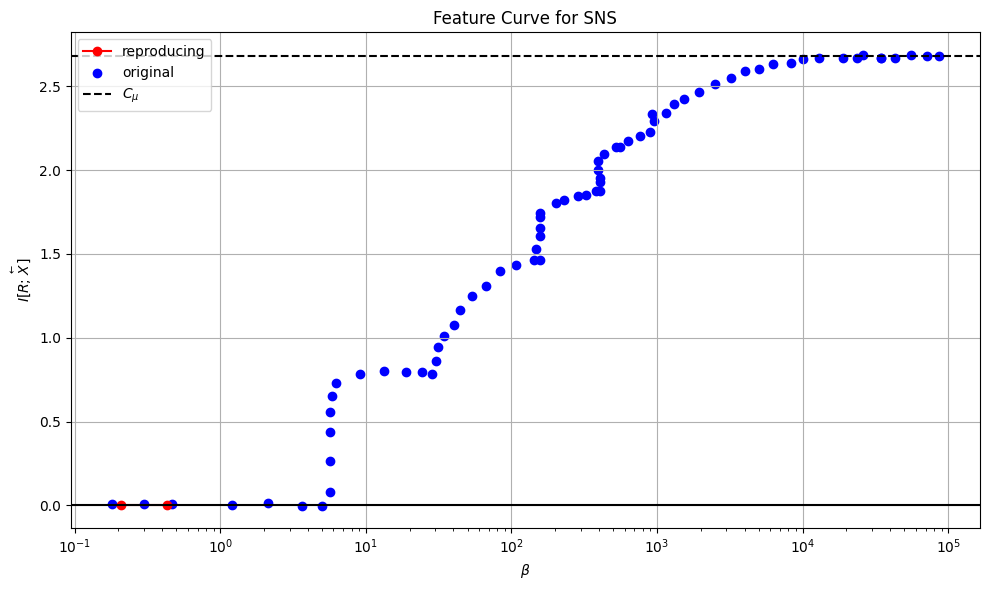

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


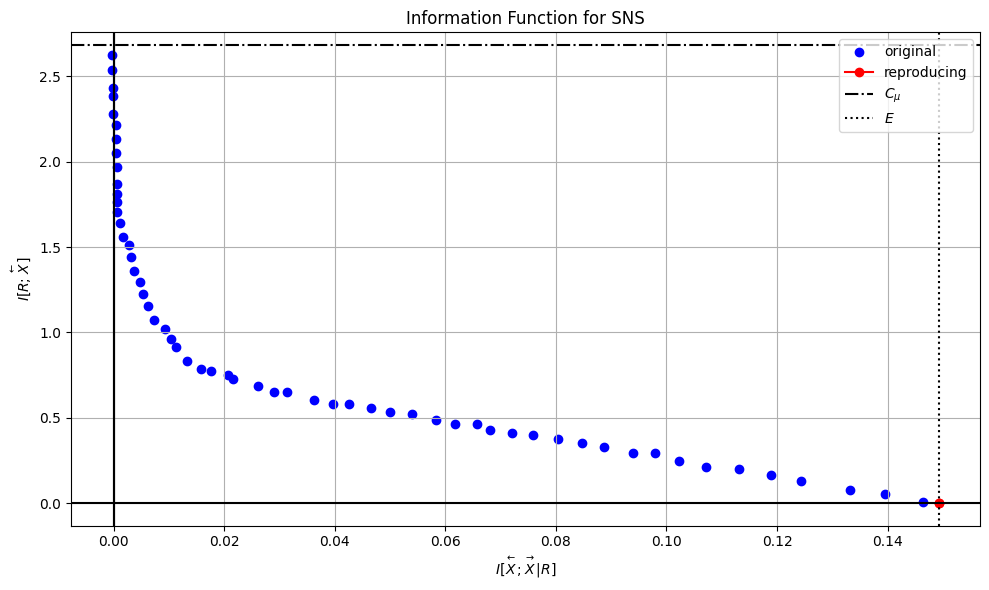

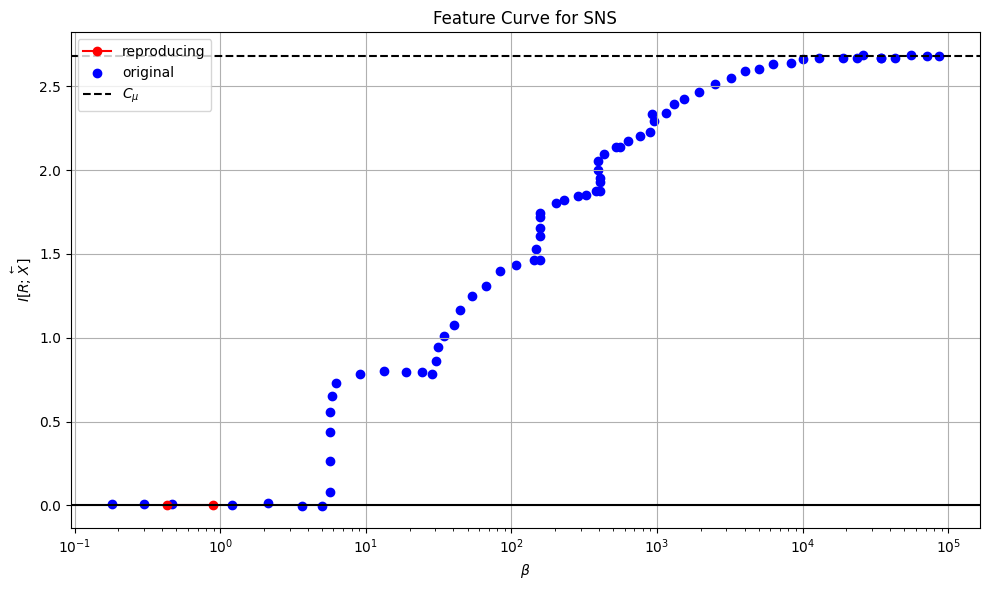

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


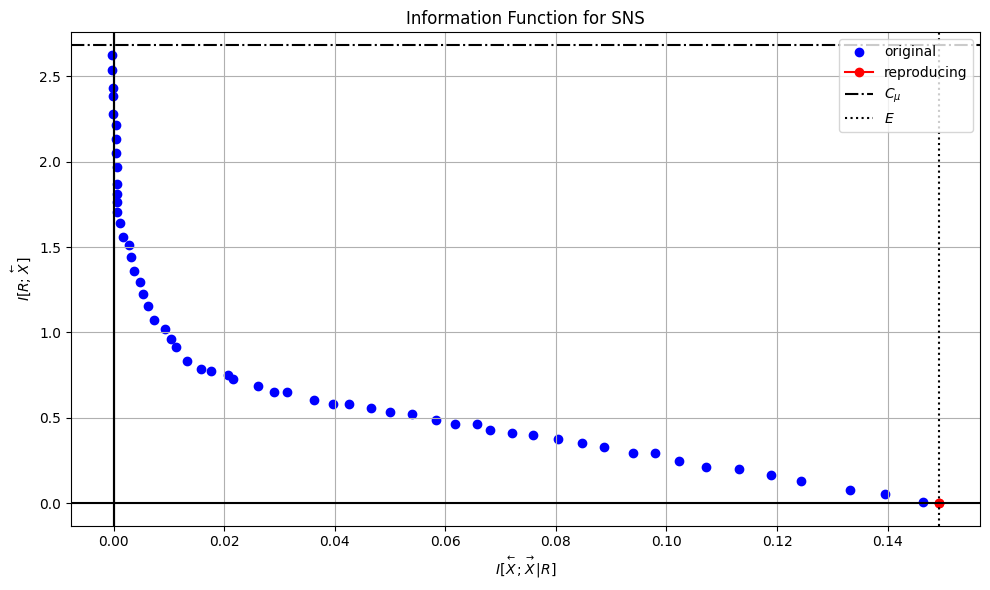

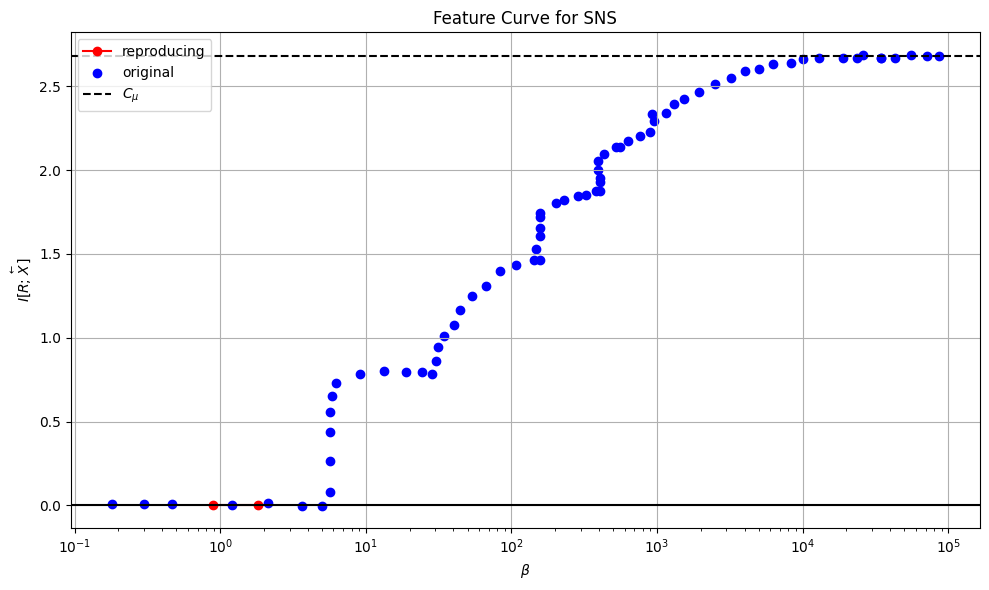

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


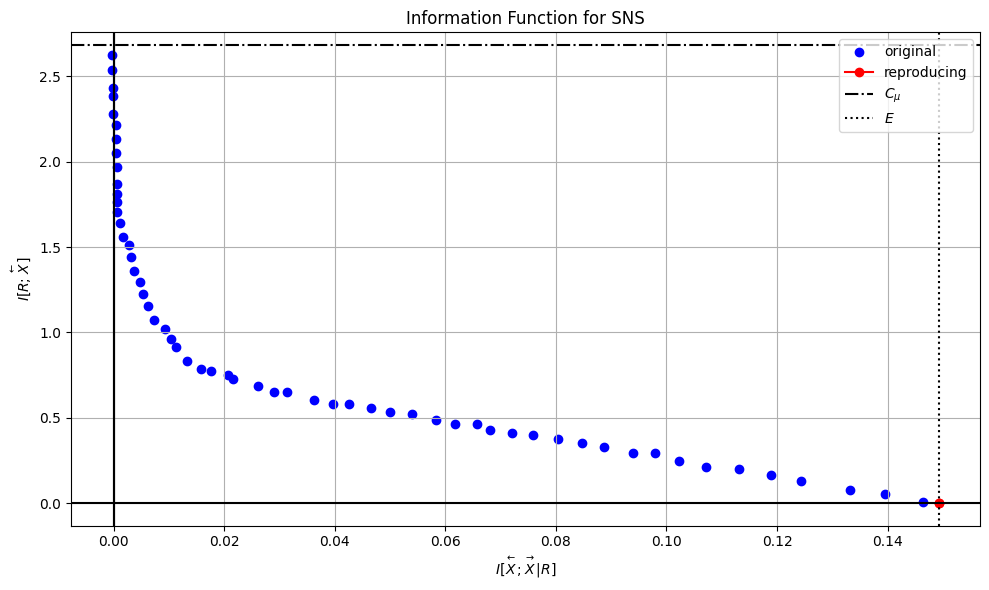

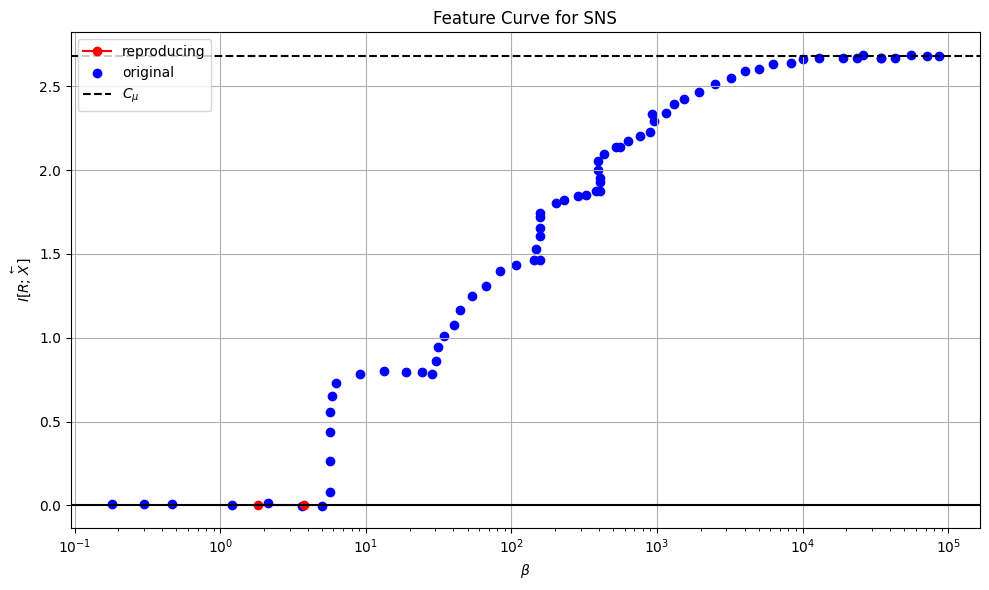

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


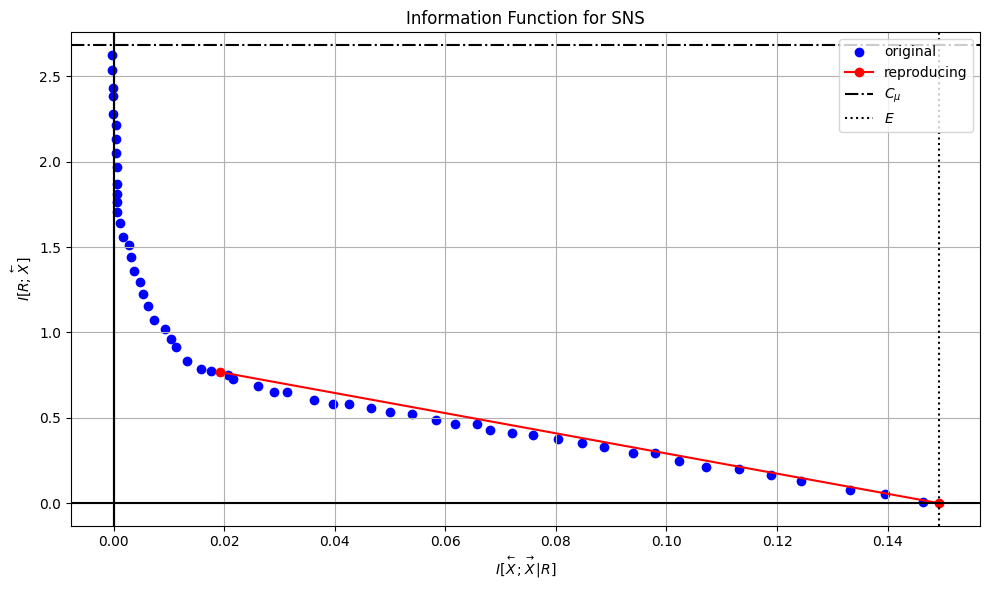

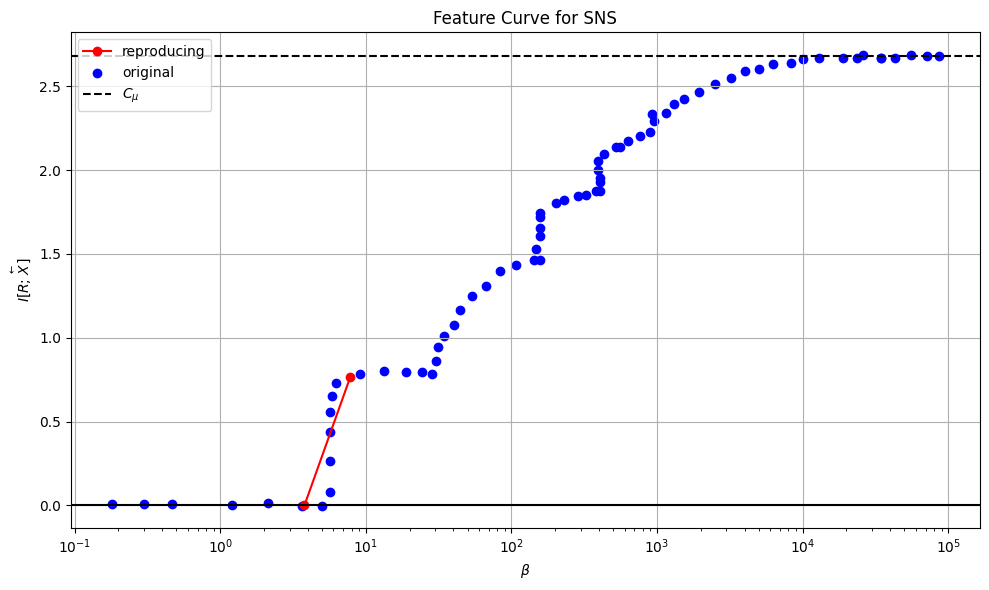

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


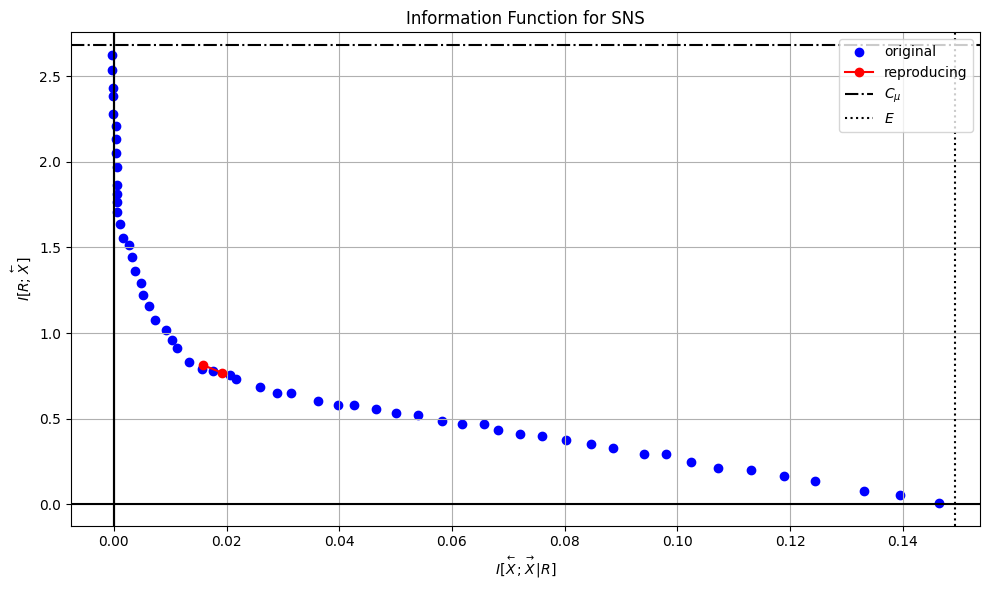

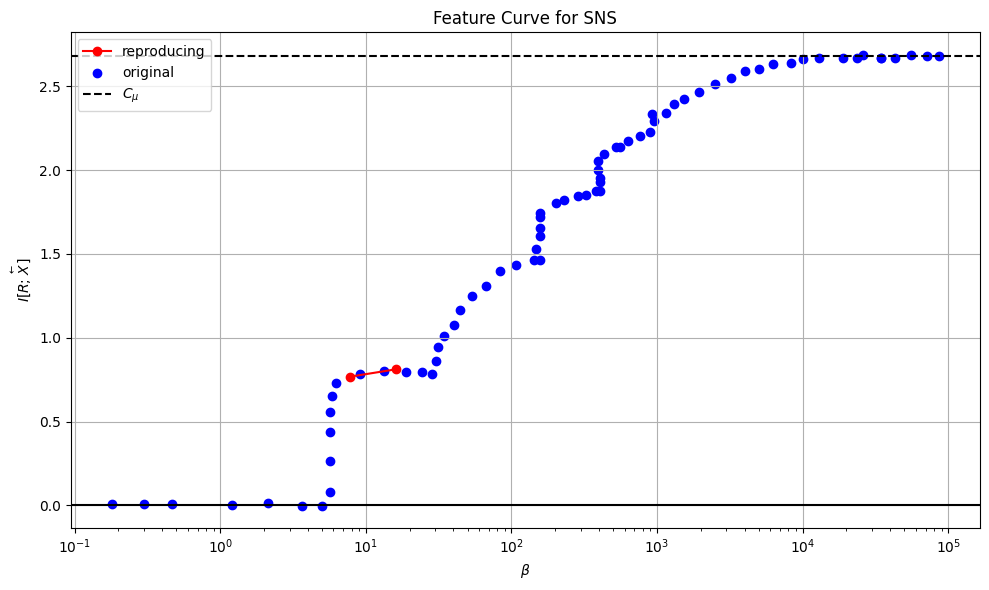

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


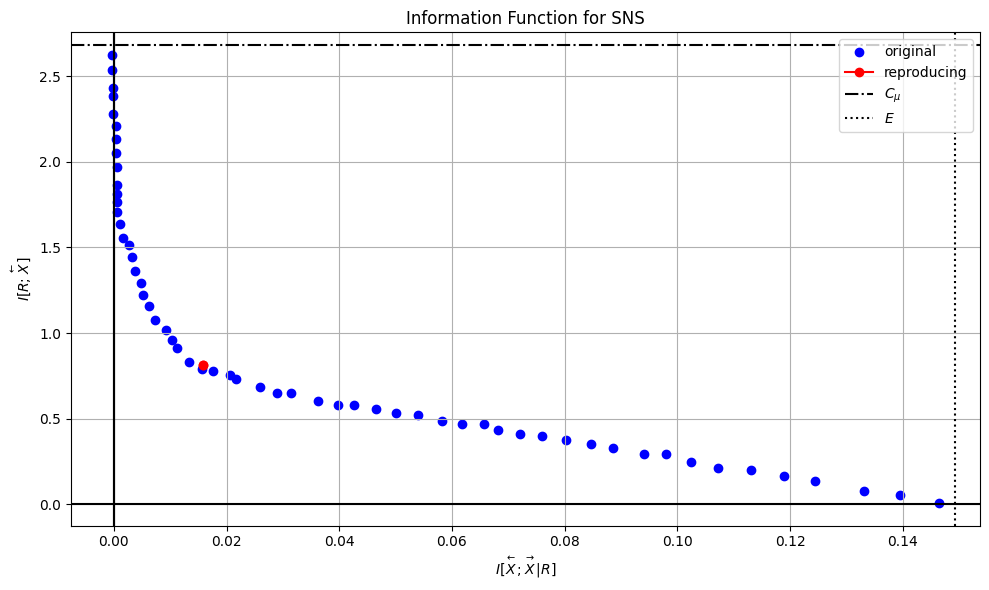

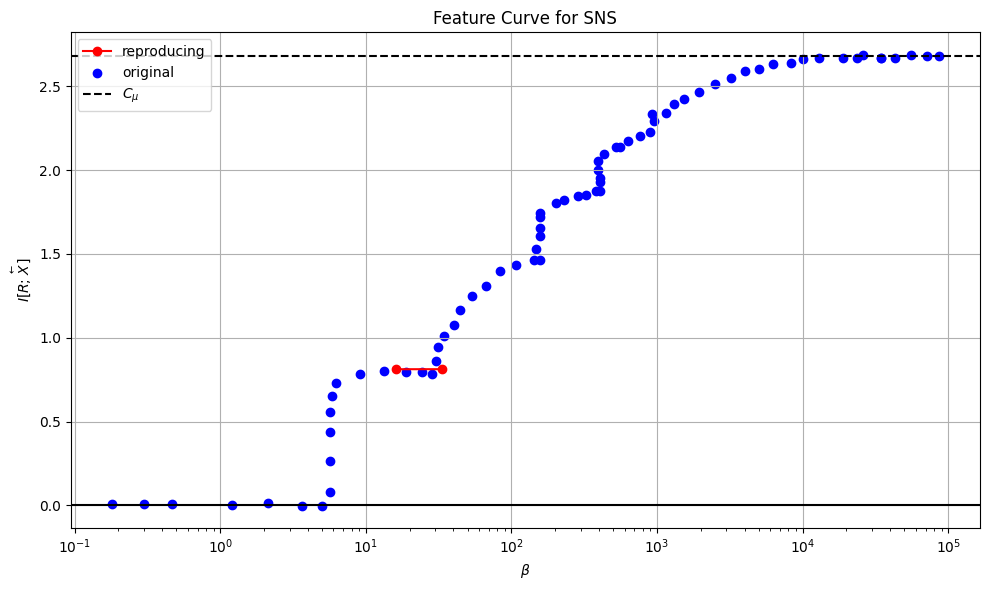

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


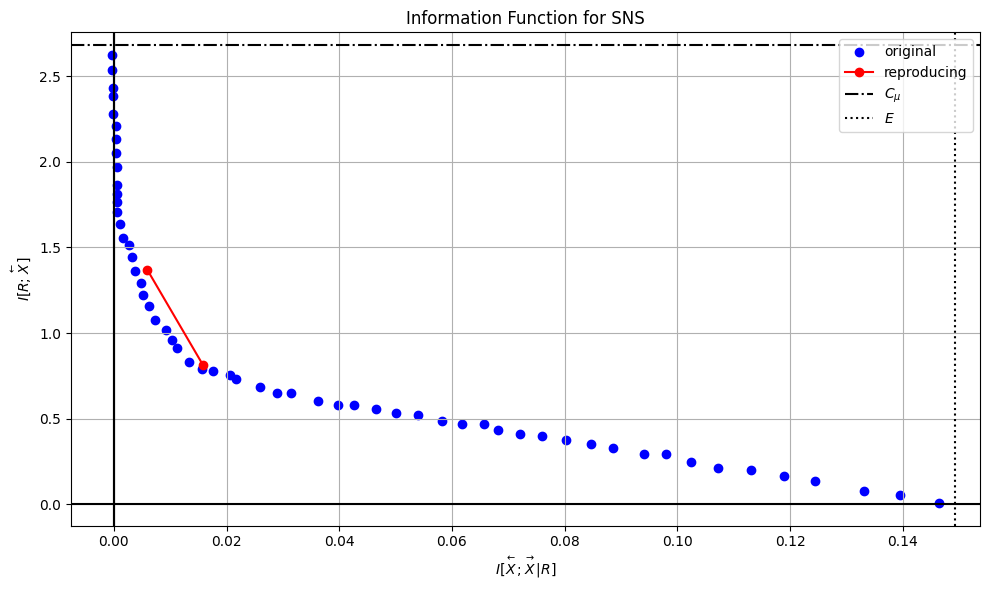

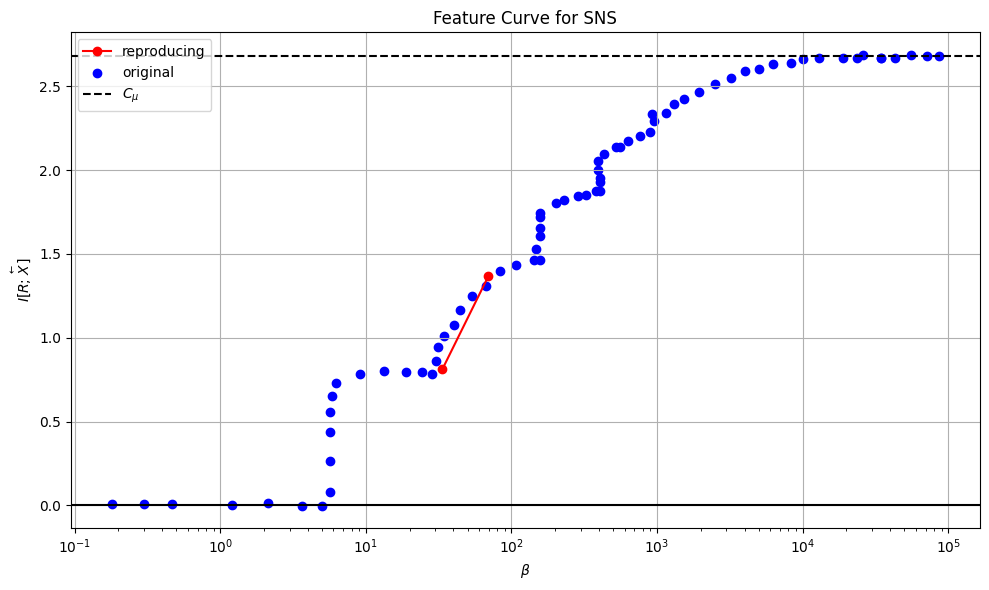

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


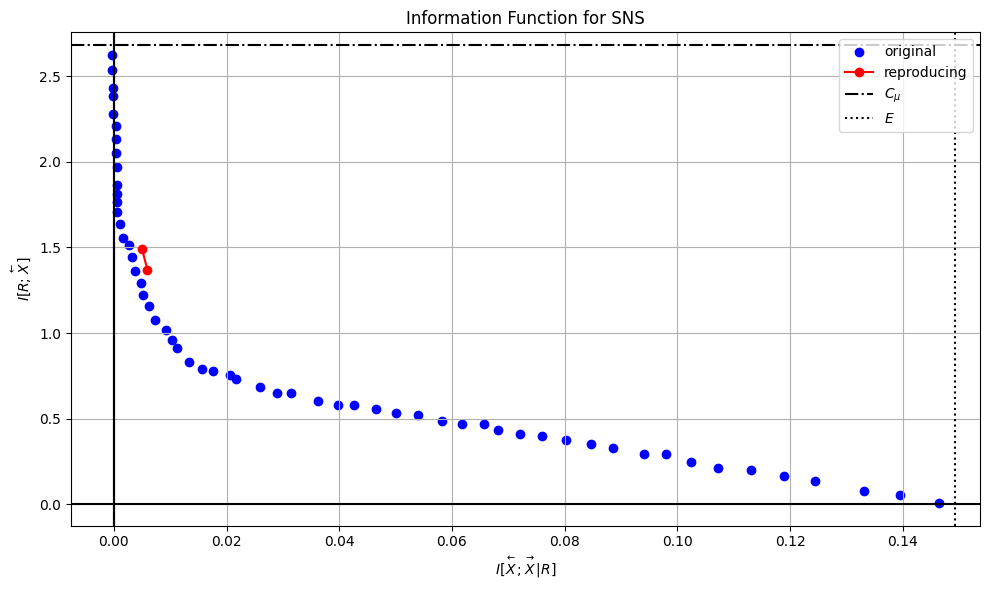

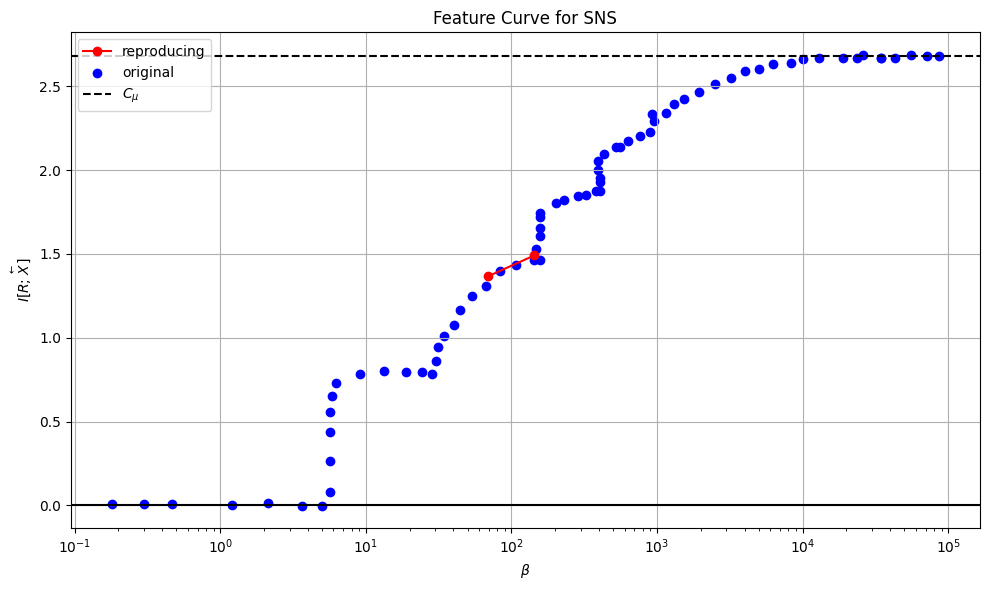

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


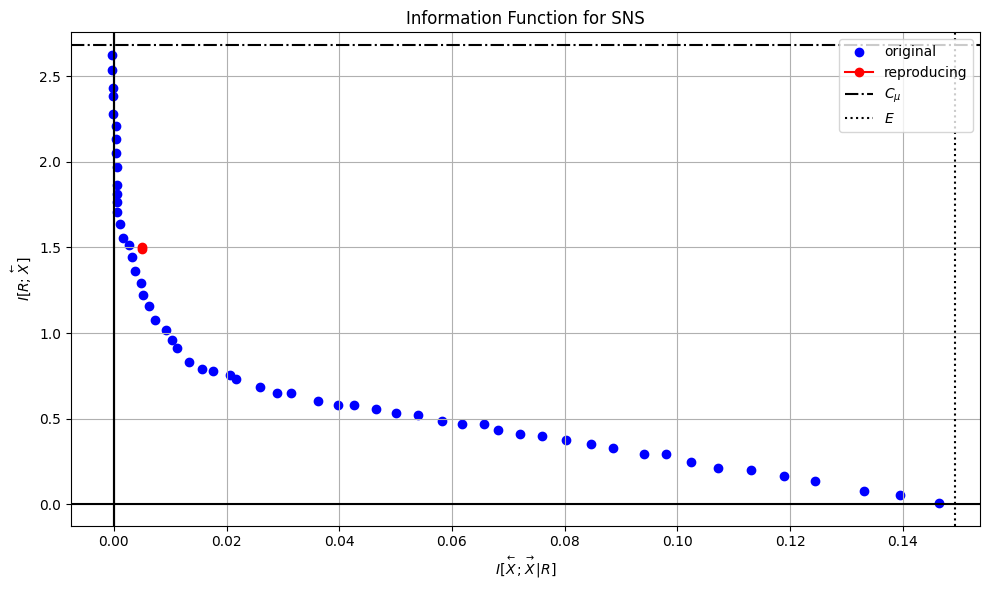

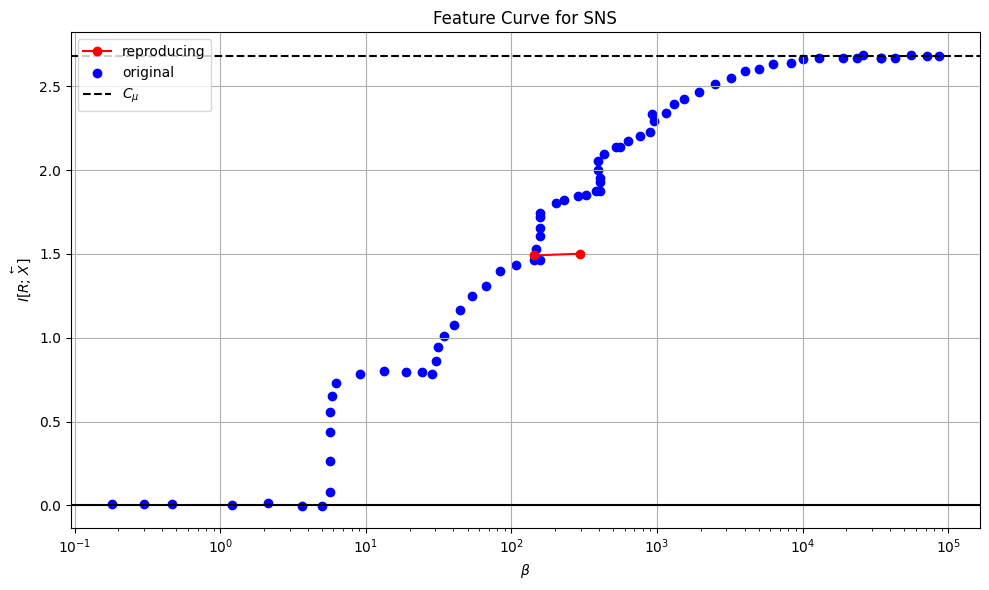

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits
Non-monotonic information function detected. Repeating with more restarts and iterations.
Still non-monotonic. Repeating with maximum restarts (5000).
Beta 297.64: Processing restart 0/5000...
Beta 297.64: Processing restart 500/5000...
Beta 297.64: Processing restart 1000/5000...
Beta 297.64: Processing restart 1500/5000...
Beta 297.64: Processing restart 2000/5000...
Beta 297.64: Processing restart 2500/5000...
Beta 297.64: Processing restart 3000/5000...
Beta 297.64: Processing restart 3500/5000...
Beta 297.64: Processing restart 4000/5000...
Beta 297.64: Processing restart 4500/5000...
Beta 615.85: Processing restart 0/5000...
Beta 615.85: Processing restart 500/5000...
Beta 615

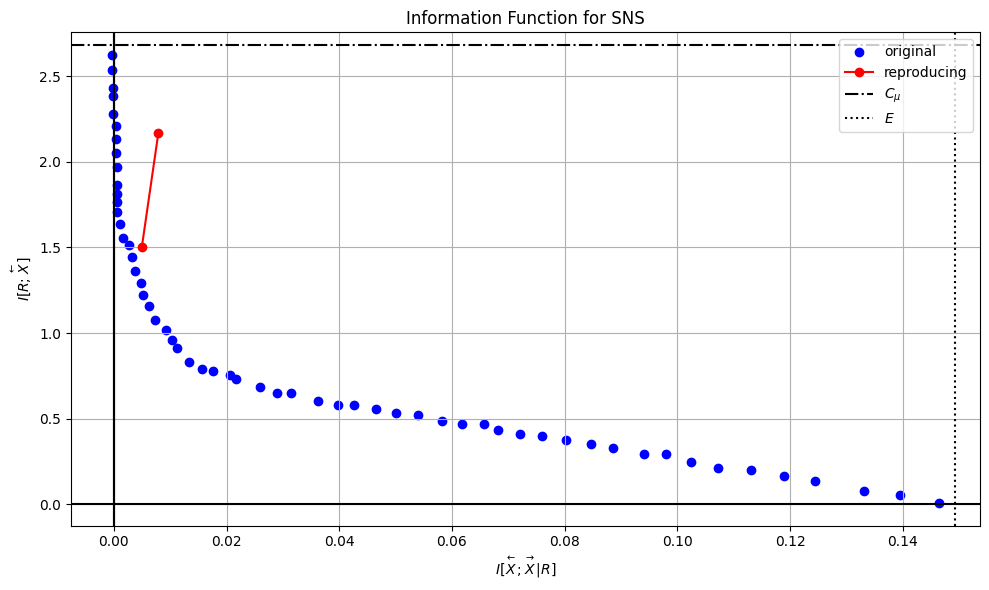

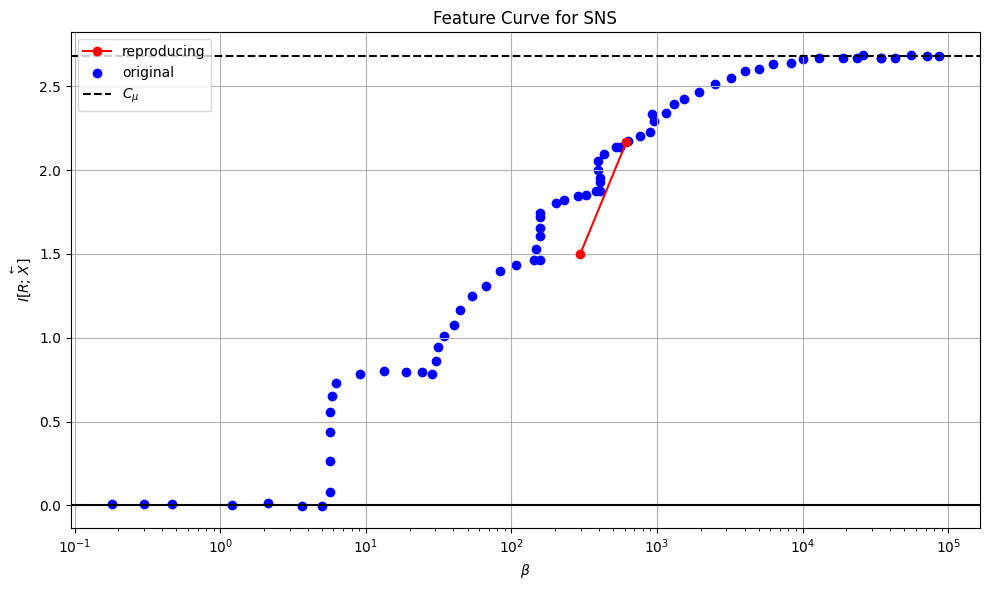

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


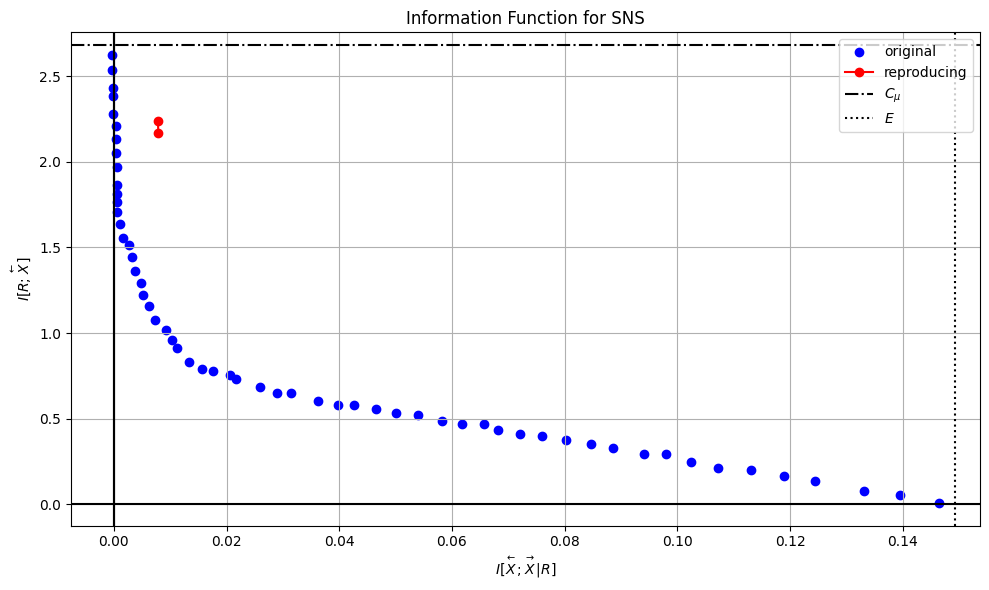

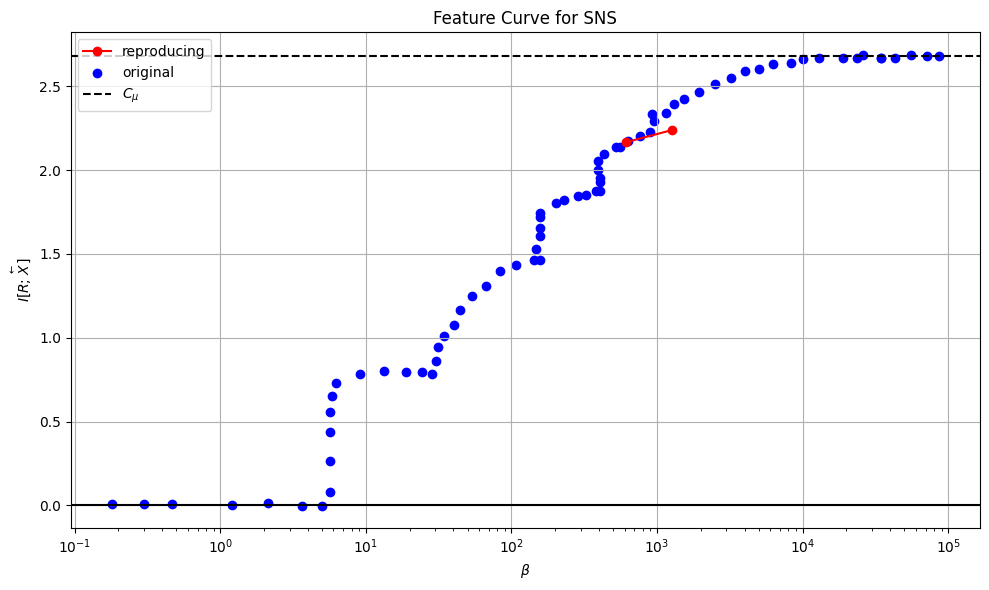

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits
Non-monotonic information function detected. Repeating with more restarts and iterations.


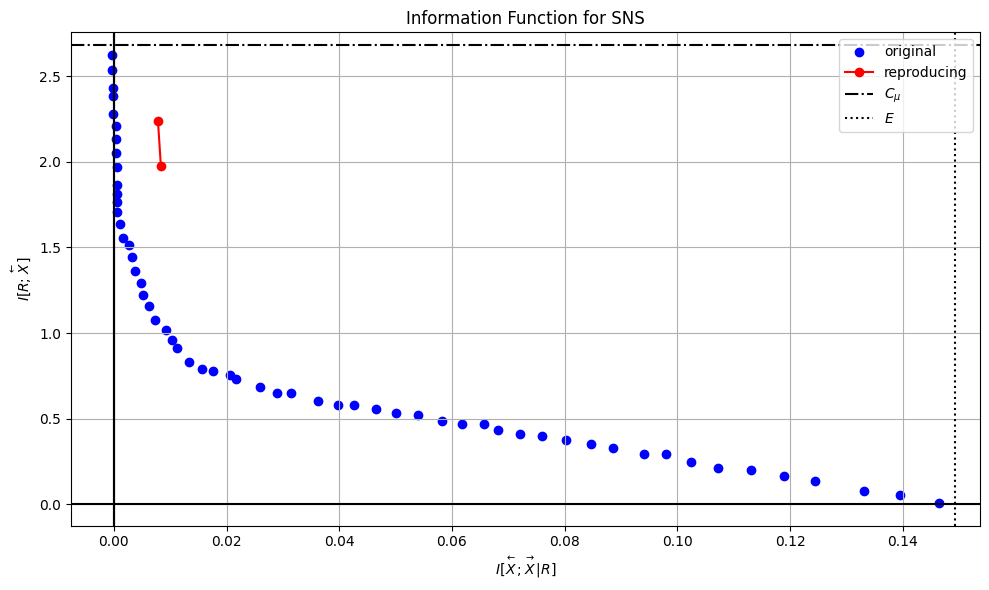

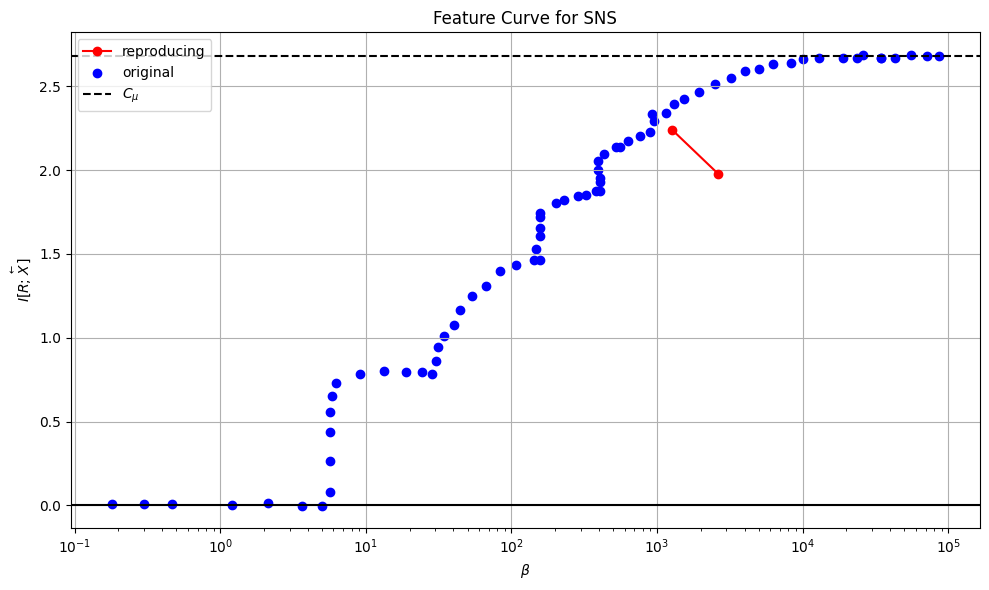

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


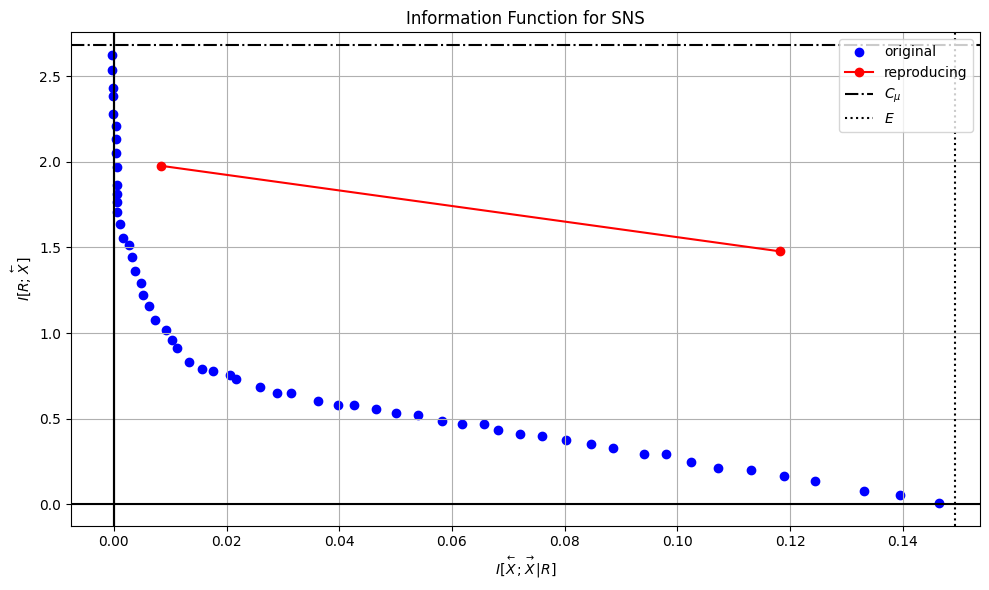

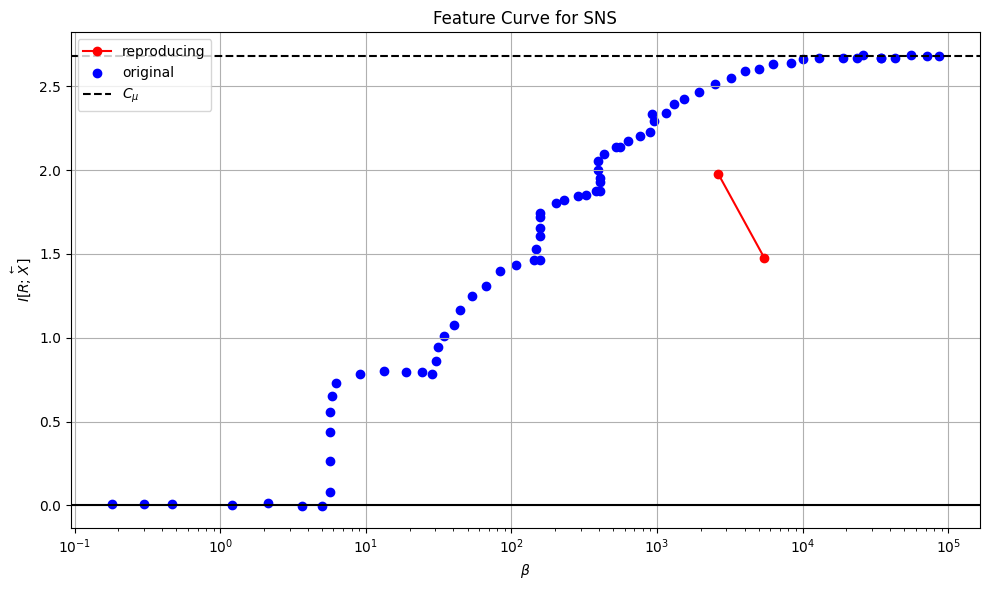

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


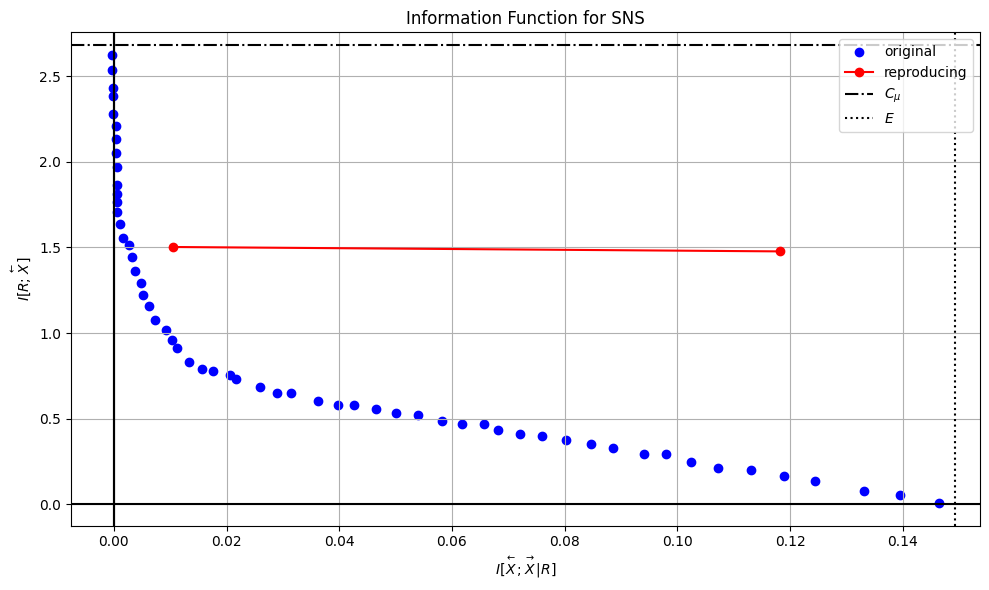

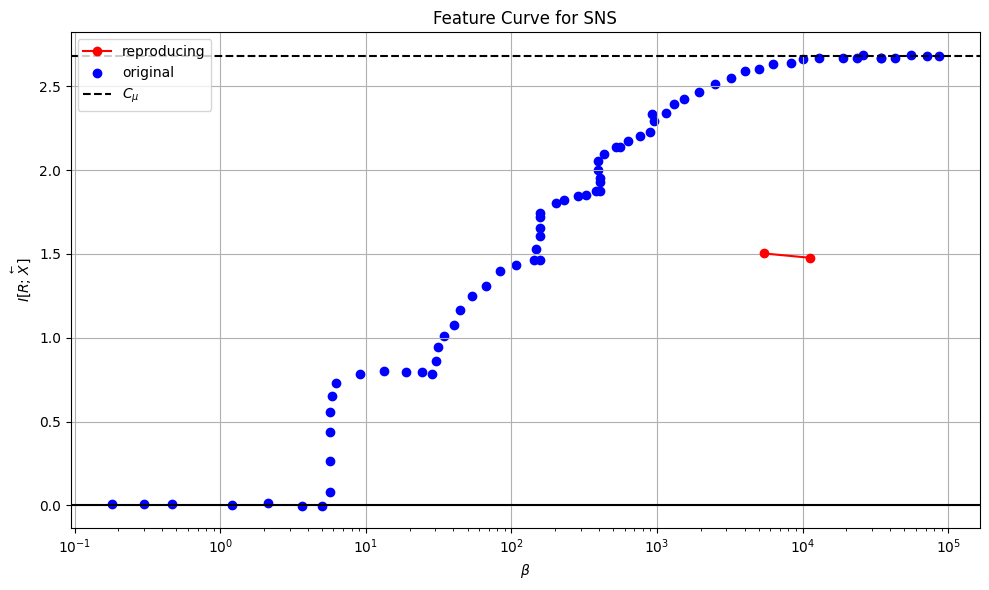

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


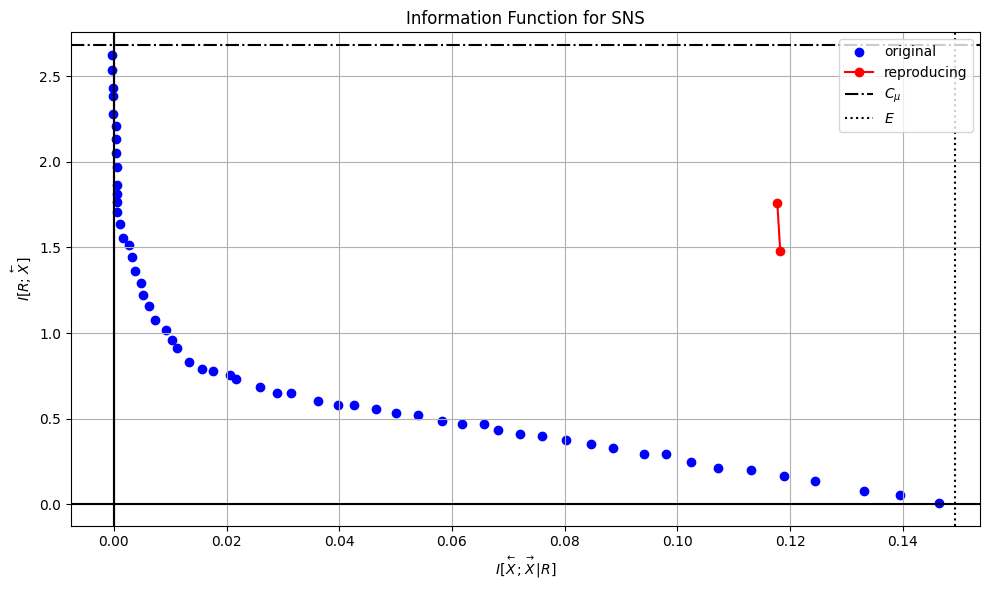

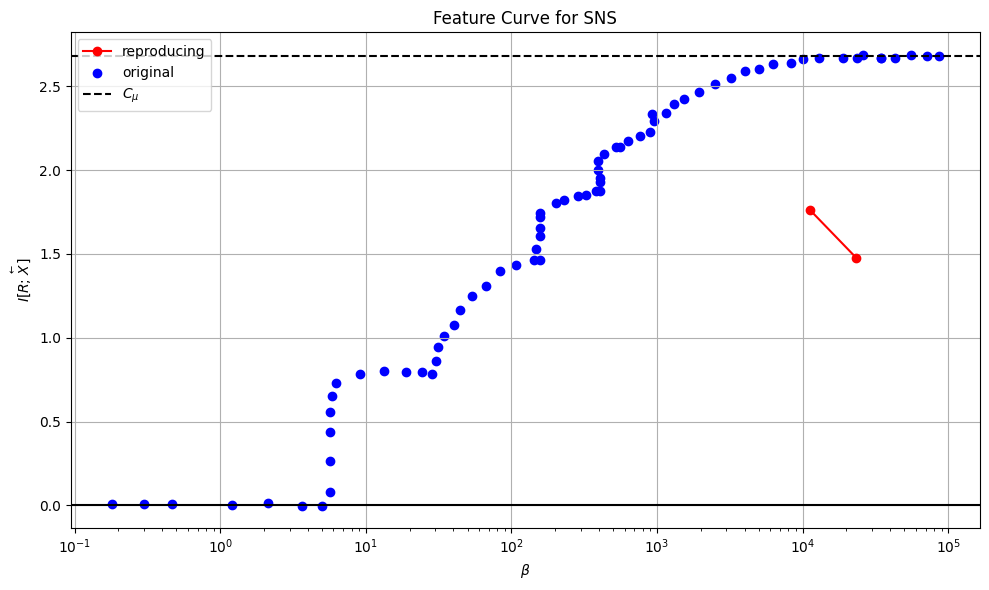

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


/tmp/ipykernel_391051/842568659.py:251: RuntimeWarning: overflow encountered in exp
  new_pt_r_given_sigma_plus[sigma_plus, r] = pt_r[r] * np.exp(-beta * kl)
/tmp/ipykernel_391051/842568659.py:256: RuntimeWarning: invalid value encountered in divide
  new_pt_r_given_sigma_plus[sigma_plus, :] /= np.sum(new_pt_r_given_sigma_plus[sigma_plus, :])


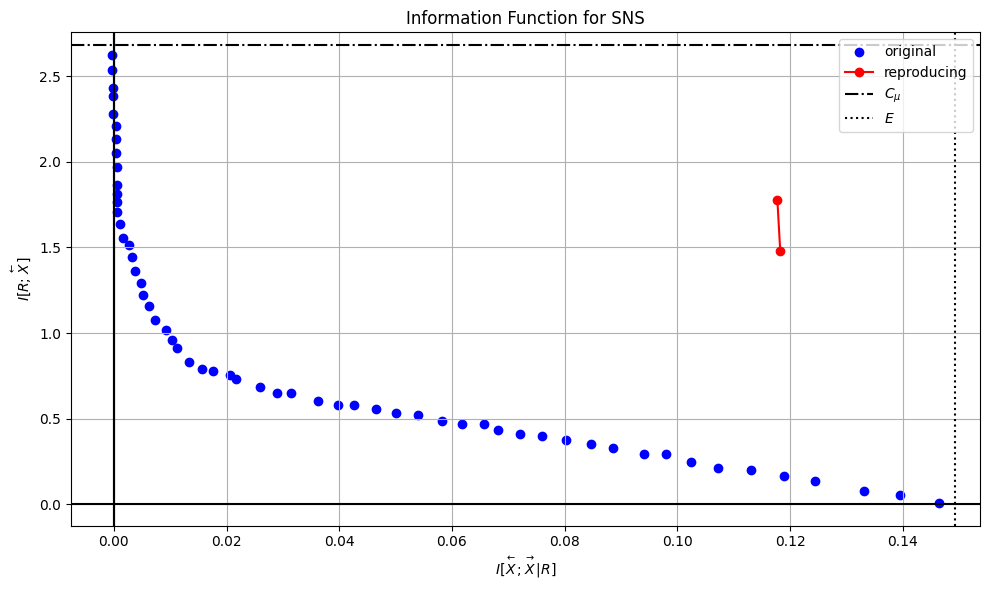

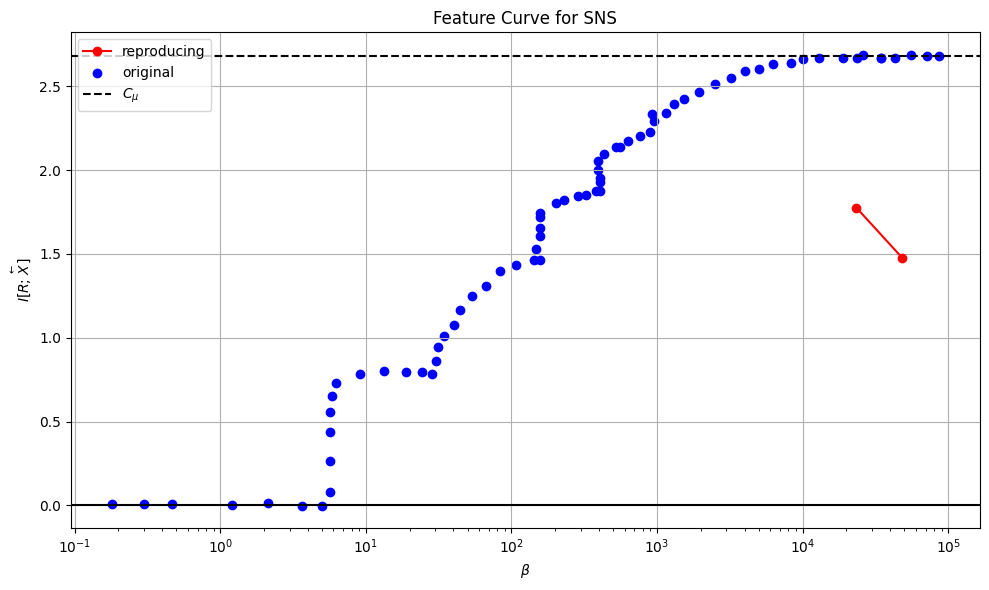

Joint distribution sum: 0.9999947548 (should be close to 1.0)
Forward state distribution sum: 0.9968261719 (should be close to 1.0)
Excess Entropy E = 0.149245 bits
Statistical Complexity C_μ = 2.682258 bits
Running Causal Information Bottleneck algorithm...
Total mutual information I[σ+;σ-] = 0.149245 bits


/tmp/ipykernel_391051/842568659.py:251: RuntimeWarning: overflow encountered in exp
  new_pt_r_given_sigma_plus[sigma_plus, r] = pt_r[r] * np.exp(-beta * kl)
/tmp/ipykernel_391051/842568659.py:256: RuntimeWarning: invalid value encountered in divide
  new_pt_r_given_sigma_plus[sigma_plus, :] /= np.sum(new_pt_r_given_sigma_plus[sigma_plus, :])


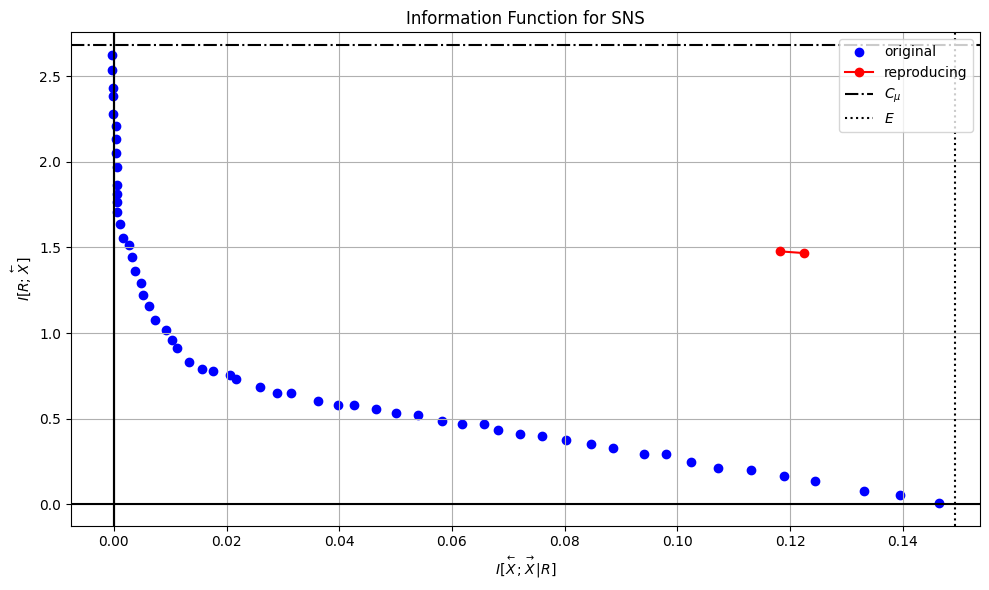

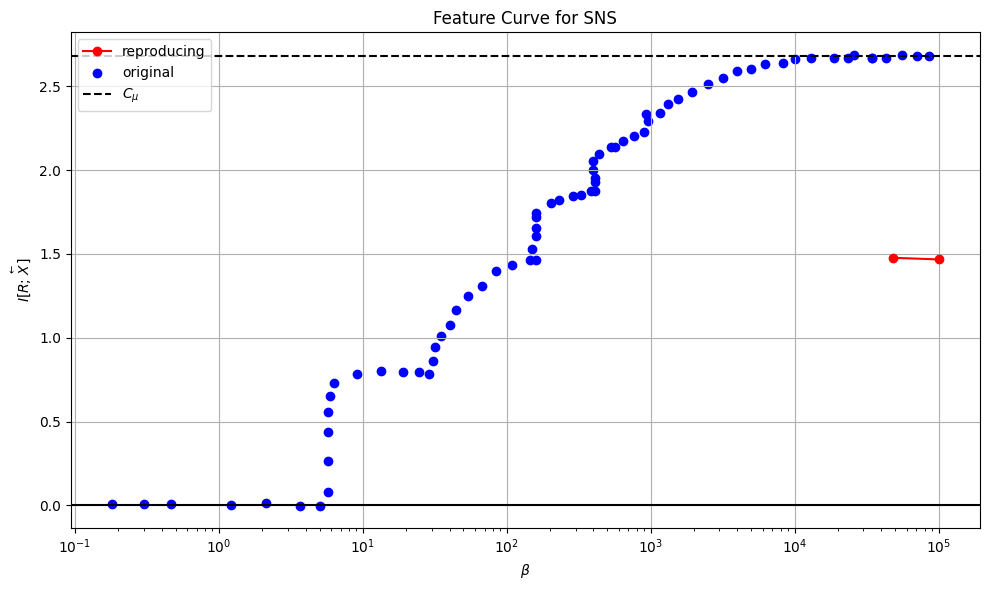

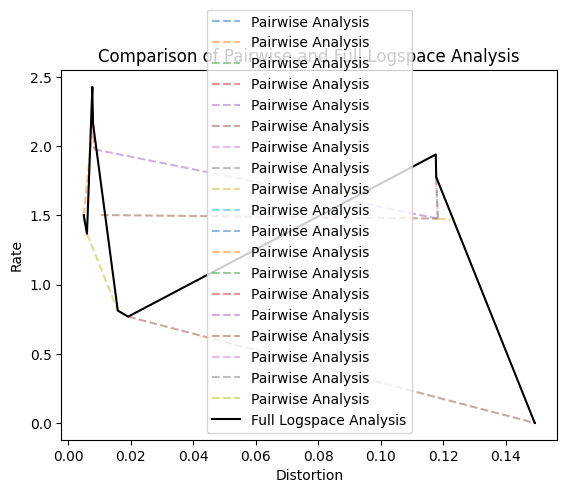

In [43]:
# Generate the logspace array
beta_values = np.logspace(-1, 5, 20)

# Initialize an array to store results from pairwise analysis
# pairwise_results = []

# Loop through pairs of beta values
# for i in range(len(beta_values) - 1):
#     beta_pair = (beta_values[i], beta_values[i + 1])
#     result = run_sns_cib_analysis(p=p, q=q, M=M, num_clusters=num_clusters, beta_values=beta_pair)
#     pairwise_results.append(result)

# Compare pairwise results to the full logspace results
full_results = results

# Plot the lines for comparison
import matplotlib.pyplot as plt

# Extract and flatten rate and distortion values for plotting
flat_rate_values = [item for res in pairwise_results for item in res[0]]
flat_distortion_values = [item for res in pairwise_results for item in res[1]]

# Sort the flattened arrays using the same arrangement as in run_sns_cib_analysis
sorted_indices = np.argsort(flat_distortion_values)
sorted_rate_values = np.array(flat_rate_values)[sorted_indices]
sorted_distortion_values = np.array(flat_distortion_values)[sorted_indices]

# Plot flattened and sorted results
plt.plot(sorted_distortion_values, sorted_rate_values, label='Flattened Pairwise Analysis', linestyle='--', alpha=0.5)

# Plot full results
plt.plot(full_results[1], full_results[0], label='Full Logspace Analysis', color='black')

plt.xlabel('Distortion')
plt.ylabel('Rate')
plt.title('Comparison of Flattened Pairwise and Full Logspace Analysis')
plt.legend()
plt.show()

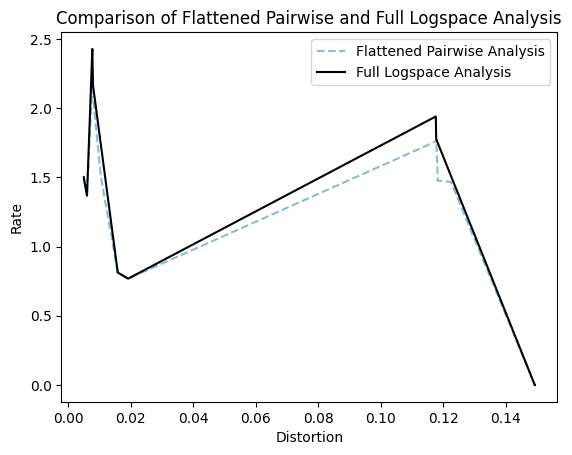

In [50]:
# Extract and flatten rate and distortion values for plotting
flat_rate_values = [item for res in pairwise_results for item in res[0]]
flat_distortion_values = [item for res in pairwise_results for item in res[1]]

# Sort the flattened arrays using the same arrangement as in run_sns_cib_analysis
sorted_indices = np.argsort(flat_distortion_values)
sorted_rate_values = np.array(flat_rate_values)[sorted_indices]
sorted_distortion_values = np.array(flat_distortion_values)[sorted_indices]

# Plot flattened and sorted results
plt.plot(sorted_distortion_values, sorted_rate_values, label='Flattened Pairwise Analysis', linestyle='--', alpha=0.5)

# Plot full results
plt.plot(full_results[1], full_results[0], label='Full Logspace Analysis', color='black')

plt.xlabel('Distortion')
plt.ylabel('Rate')
plt.title('Comparison of Flattened Pairwise and Full Logspace Analysis')
plt.legend()
plt.show()